In [ ]:
! pip install statsmodels ipywidgets dask dask-ml > /dev/null


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import scipy
from scipy import stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import glob
import dask.dataframe as dd
from dask_ml.linear_model import LinearRegression
import dask
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 3: Missing values

In [ ]:
data = dd.read_parquet('data/data-merged-v7-partial.parquet')

# data = dd.read_parquet('data/data-merged-v9.parquet')


data2 = data.copy()
data3 = data.copy()



# Directory containing your Parquet files
parquet_files_dir = '/work/data/by-vin-v11'

# List all Parquet files in the directory
parquet_files = [
    os.path.join(parquet_files_dir, f) 
    for f in os.listdir(parquet_files_dir) 
    if f.endswith('.parquet')
]

# Function to read a Parquet file and add a filename column
def read_parquet_with_filename(filepath):
    # Read the Parquet file
    df = dd.read_parquet(filepath)
    # Add a column with the filename
    df['source_file'] = str(os.path.basename(filepath))
    return df

ddf_list = [
    read_parquet_with_filename(f) for f in parquet_files
]  


In [ ]:
ddf_list[9].head()


,record_time,soc,pack_voltage (V),charge_current (A),max_cell_voltage (V),min_cell_voltage (V),max_temperature (℃),min_temperature (℃),available_energy (kw),available_capacity (Ah),source_file,time_diff,new_session,charging_type
0,2019-07-26 02:53:18,23.200001,327.200012,-52.200008,3.652,3.628,36,34,10.48,31.510000,18.parquet,0.0,900000000,DC
1,2019-07-26 02:53:26,23.200001,327.399994,-52.200008,3.655,3.632,36,34,10.52,31.629999,18.parquet,8.0,900000000,DC
2,2019-07-26 02:53:34,23.200001,327.700012,-52.200008,3.657,3.633,36,34,10.55,31.740000,18.parquet,8.0,900000000,DC
3,2019-07-26 02:53:42,23.600000,327.700012,-52.200008,3.658,3.634,36,34,10.60,31.870001,18.parquet,8.0,900000000,DC
4,2019-07-26 02:53:50,23.600000,327.799988,-52.200008,3.660,3.635,36,34,10.64,31.990000,18.parquet,8.0,900000000,DC


## Code: Grouping data into weeks

In [ ]:

def compute_AC_DC_by_sessions(data, mode='M'):
    import pandas as pd
    import dask.dataframe as dd
    from datetime import datetime, timedelta

    weeks_data = data.copy()
    weeks_data['record_time'] = dd.to_datetime(weeks_data['record_time'])

    # Group by 'new_session' to get the minimum 'record_time' for each session
    sessions_by_week = weeks_data.groupby('new_session').min().reset_index()
    # Select the desired columns
    sessions_by_week = sessions_by_week[[
        'charging_type', 'record_time', 'new_session',
        ]]

    # Convert 'record_time' to datetime
    sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])

    # Set 'record_time' as the index
    sessions_by_week = sessions_by_week.set_index('record_time')

    # Compute the DataFrame to bring it into memory
    sessions_by_week = sessions_by_week.compute()

    # Resample by week and count the 'new_session' column grouped by 'charging_type'
    sessions_result = sessions_by_week.groupby([pd.Grouper(freq=mode), 'charging_type']).new_session.count().unstack(fill_value=0)

    return dd.from_pandas(sessions_result)

sessions_results = [
    compute_AC_DC_by_sessions(data, mode='W')
    for data in ddf_list ]


In [ ]:
sessions_results[0].head(20)

charging_type,AC,DC
record_time,,
2019-07-28,0,3
2019-08-04,7,9
2019-08-11,1,9
2019-08-18,2,10
2019-08-25,1,9
2019-09-01,0,10
2019-09-08,0,15
2019-09-15,1,11
2019-09-22,1,11


In [ ]:

def compute_monthly_capacity_change(data, mode='M'):
    # Only consider data points from when almost fully charged
    df = data[data['soc'] >= 90].compute()  

    # Step 1: Resample the Data Weekly to get the maximum capacity
    df['record_time'] = pd.to_datetime(df['record_time'])
    df = df.set_index('record_time')

    df['full_capacity'] = df['available_capacity (Ah)'] / (df['soc']/ 100)

    # Resample to get the maximum available capacity for each week / month
    monthly_capacity = df['full_capacity'].resample(mode).max().dropna()

    # Step 2: Calculate Monthly Capacity Change
    monthly_capacity_change = monthly_capacity.diff().dropna()

    monthly = monthly_capacity_change.to_frame()
    monthly = monthly.rename(columns={'full_capacity': 'capacity_change'})
    monthly['capacity'] = monthly_capacity
    return dd.from_pandas(monthly)


# monthly = compute_monthly_capacity_change(data, mode='M')
# print(monthly.head())

monthly_ddfs = [
    compute_monthly_capacity_change(data, mode='M')
    for data in ddf_list ]

weekly = compute_monthly_capacity_change(data, mode='W')

weekly_ddfs = [
    compute_monthly_capacity_change(data, mode='W')
    for data in ddf_list ]

In [ ]:
weekly_ddfs[0].head(200)

,capacity_change,capacity
record_time,,
2019-08-04,0.000000,136.444672
2019-08-11,0.007294,136.451965
2019-08-18,0.000000,136.451965
2019-08-25,0.003586,136.455551
2019-09-01,-0.003586,136.451965
...,...,...
2021-10-24,-0.272598,131.582962
2021-10-31,-0.158920,131.424042
2021-11-07,-0.262543,131.161499


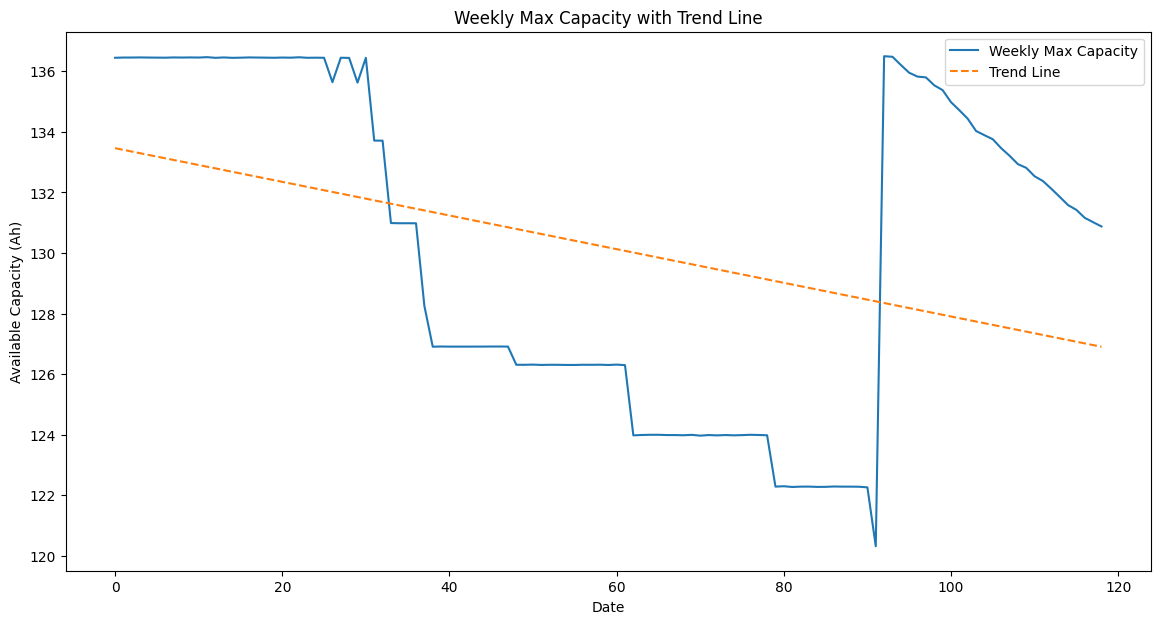

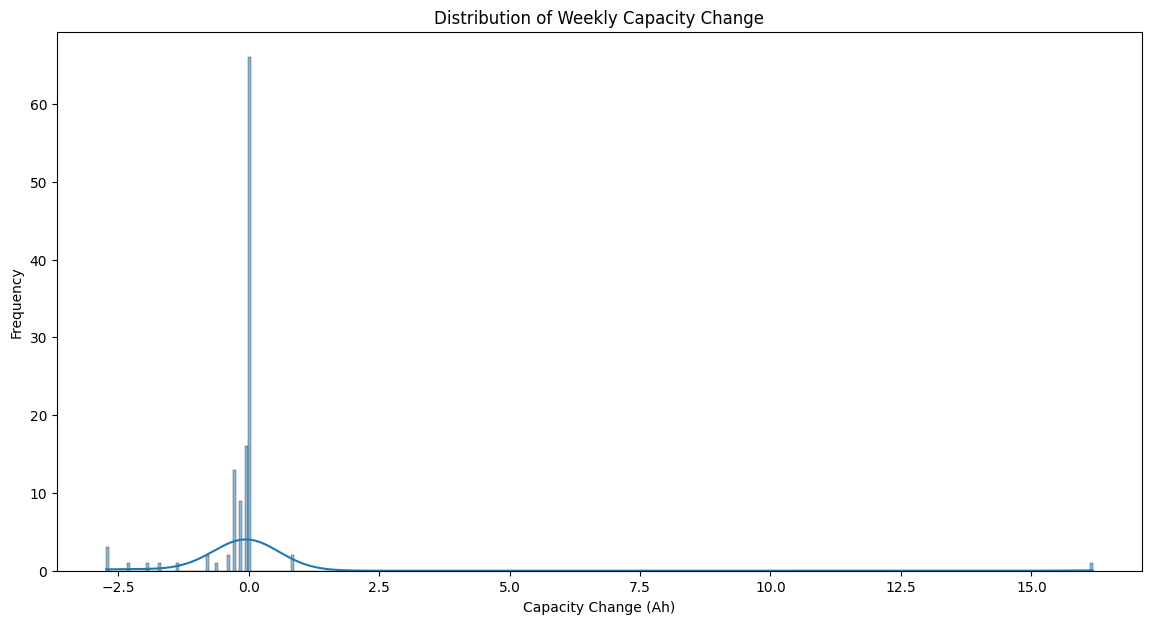

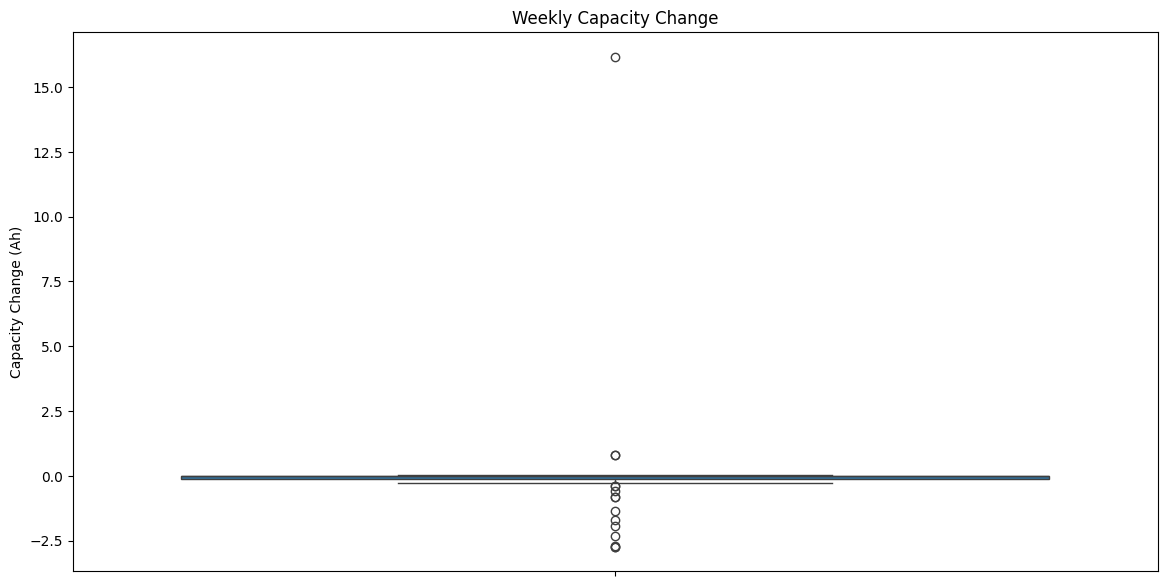

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 133.46030899176077
Slope: -0.05555030812974025

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


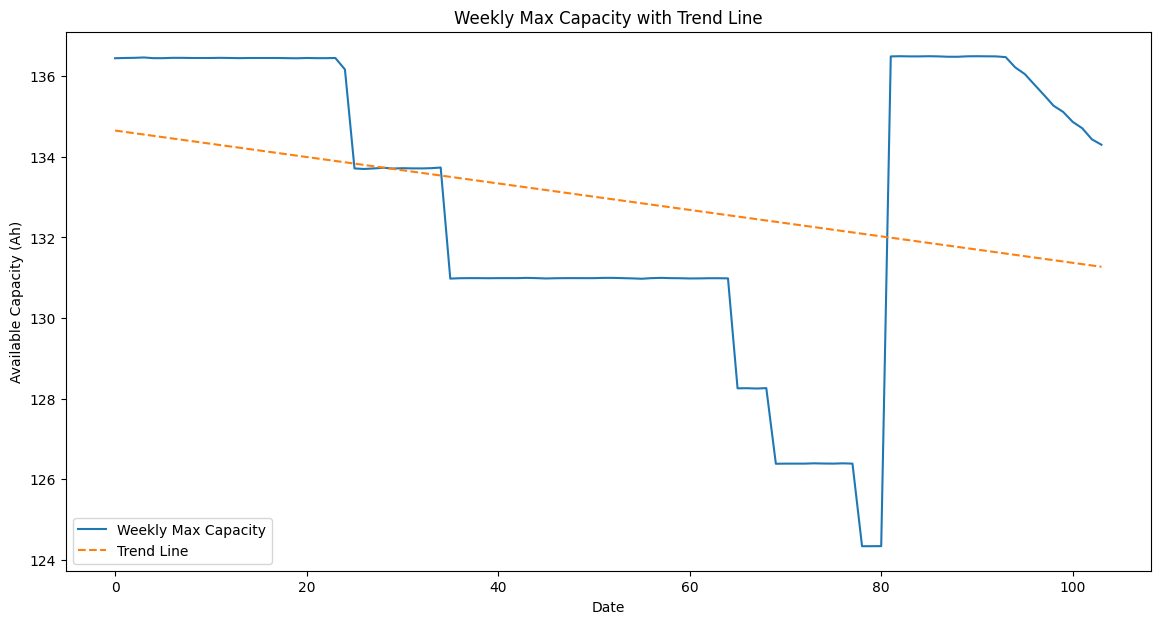

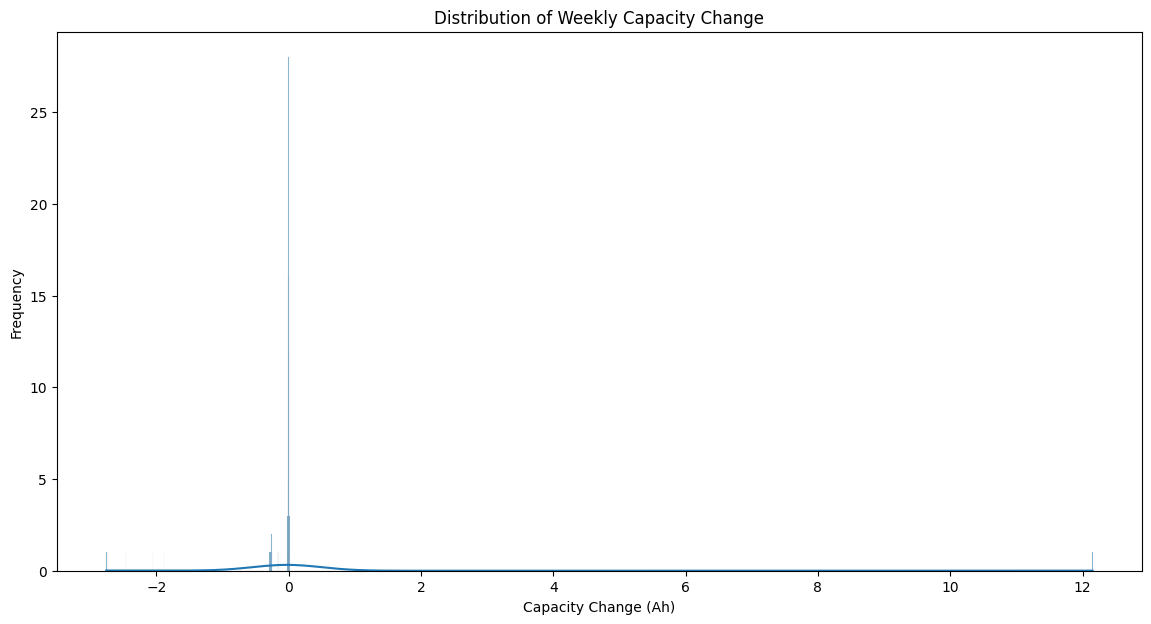

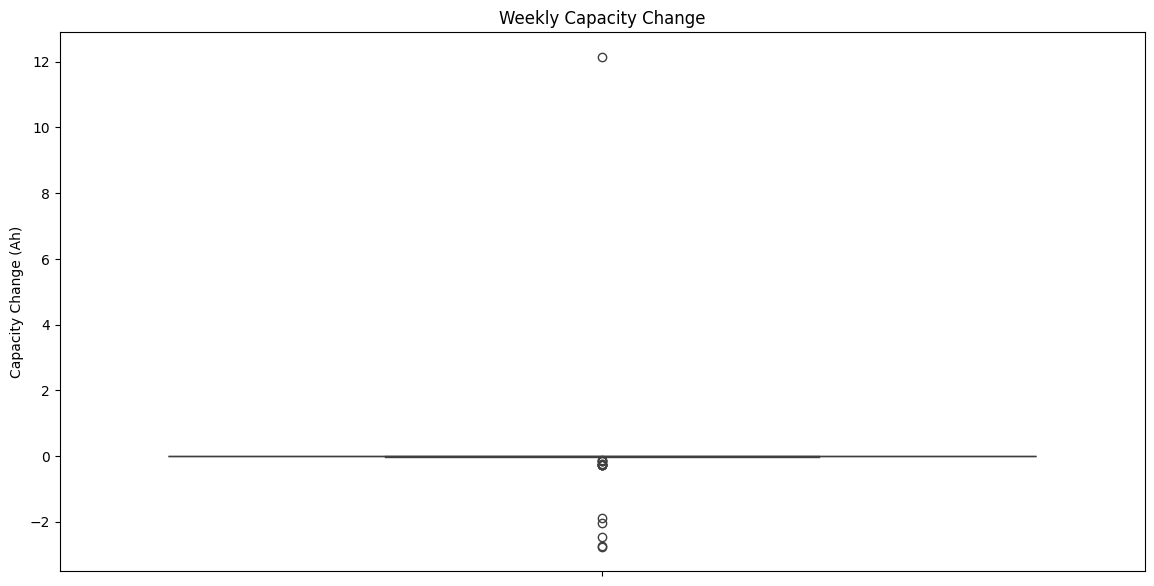

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 134.65136322608362
Slope: -0.03282135898627123

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


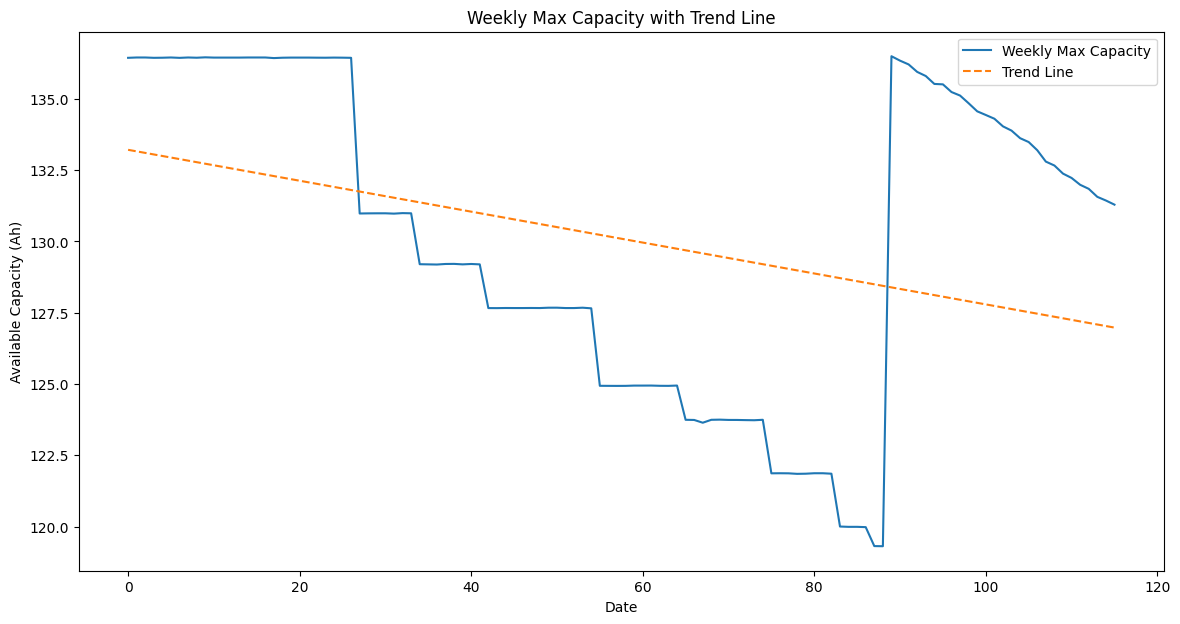

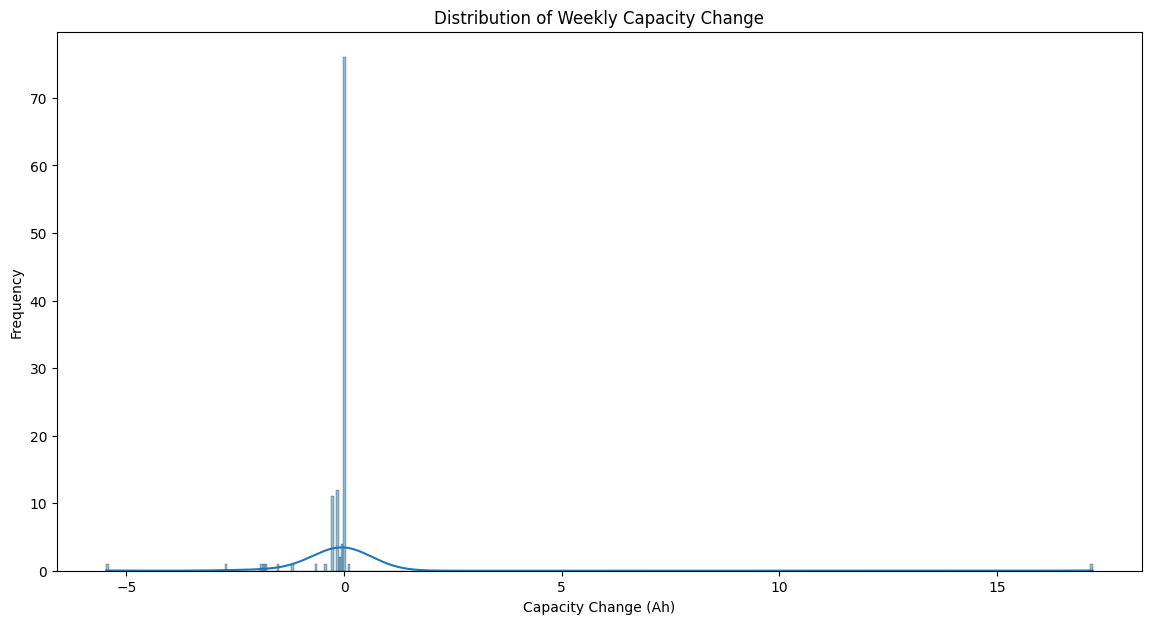

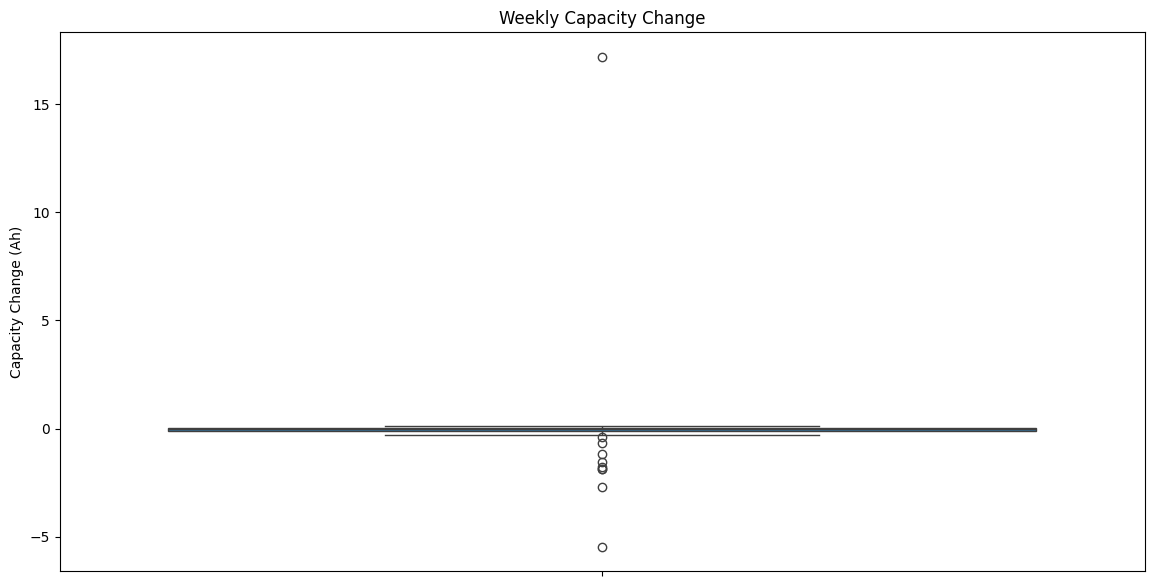

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 133.21651296505985
Slope: -0.05423246476127172

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


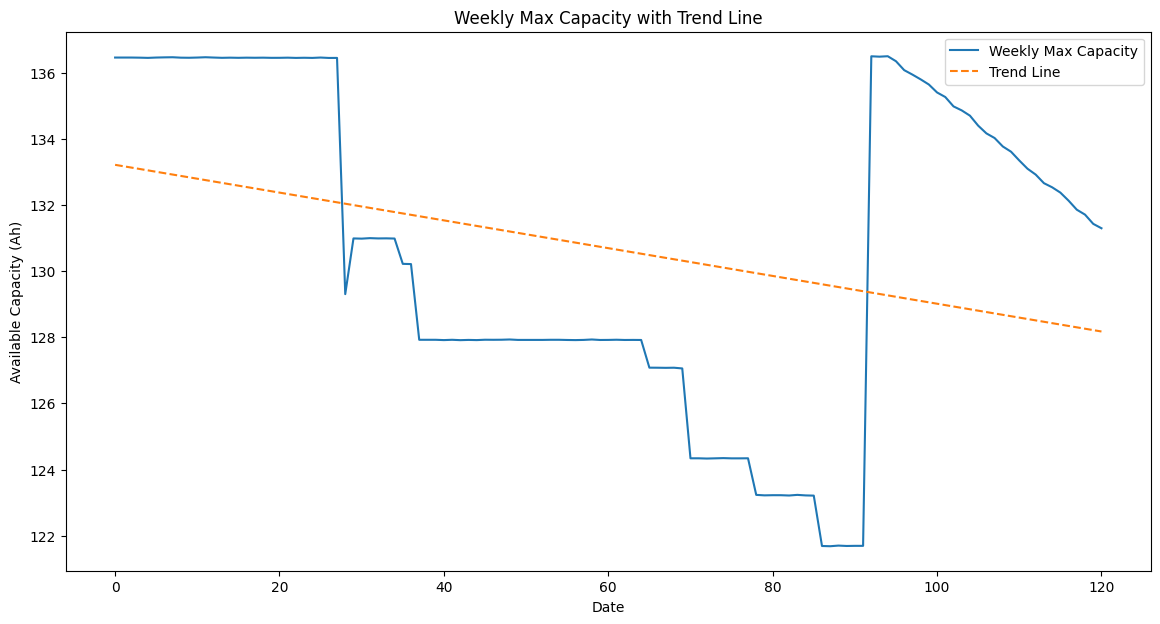

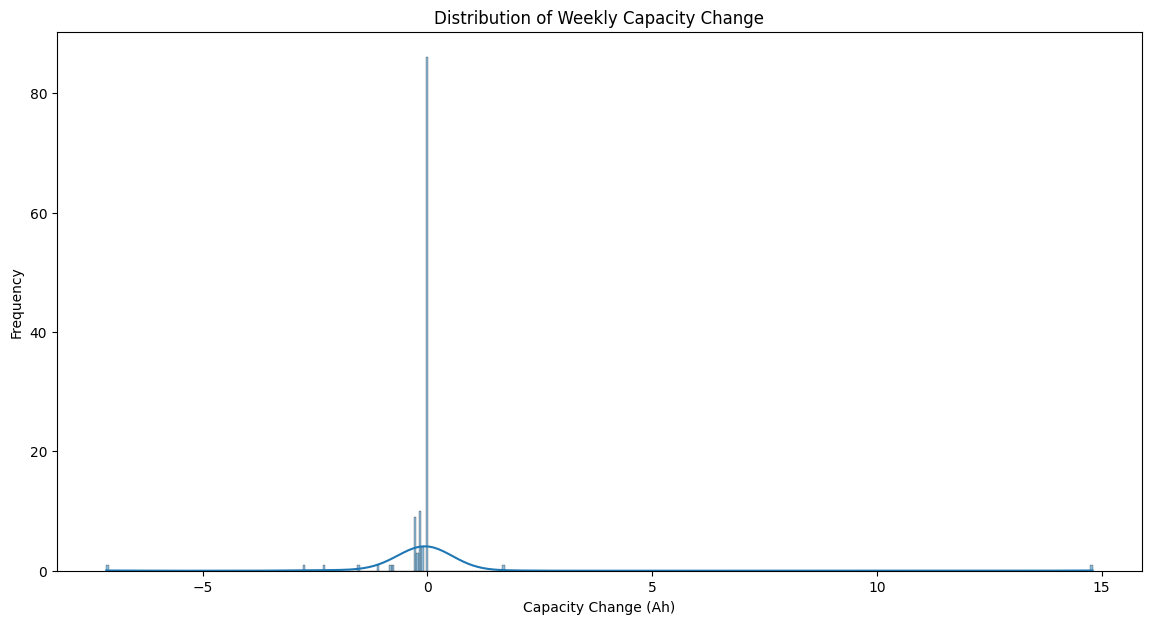

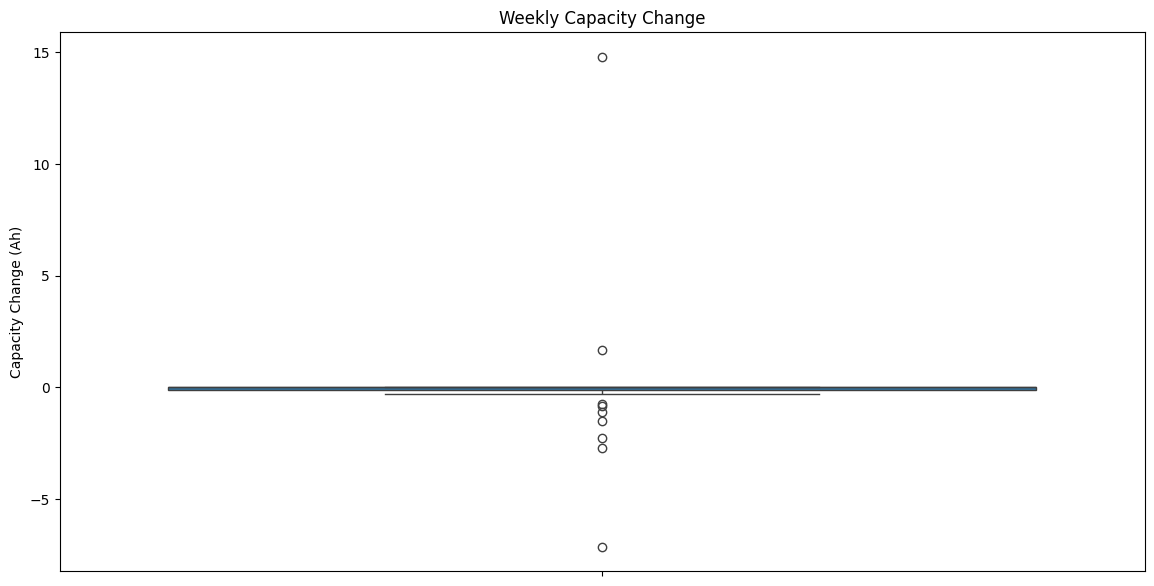

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 133.21216494977966
Slope: -0.04199281172318893

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


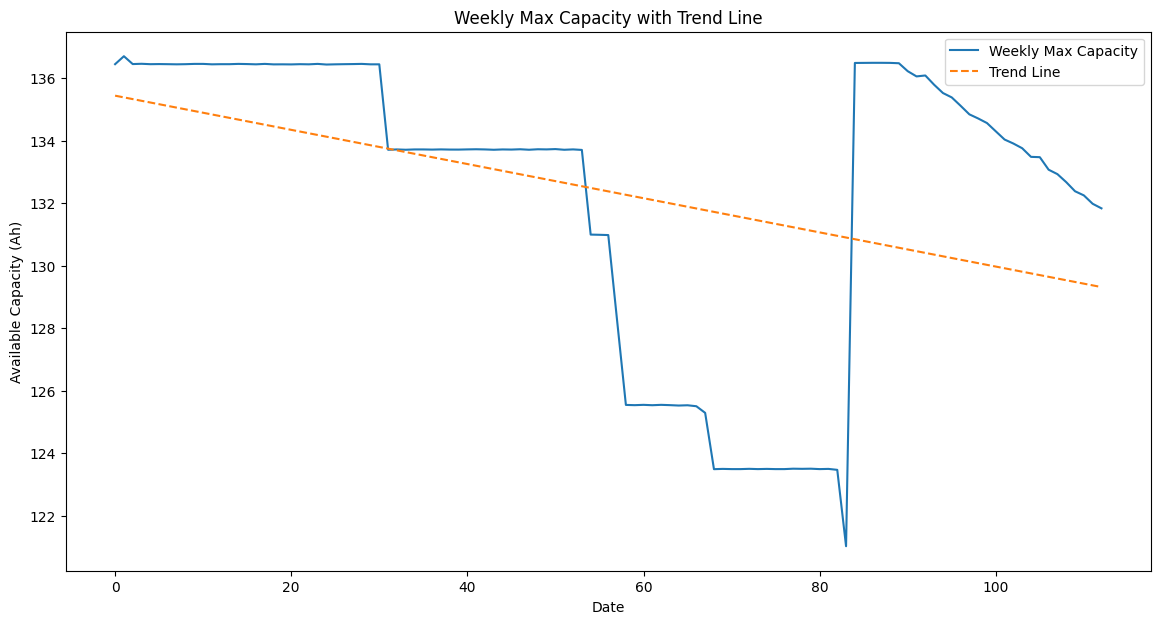

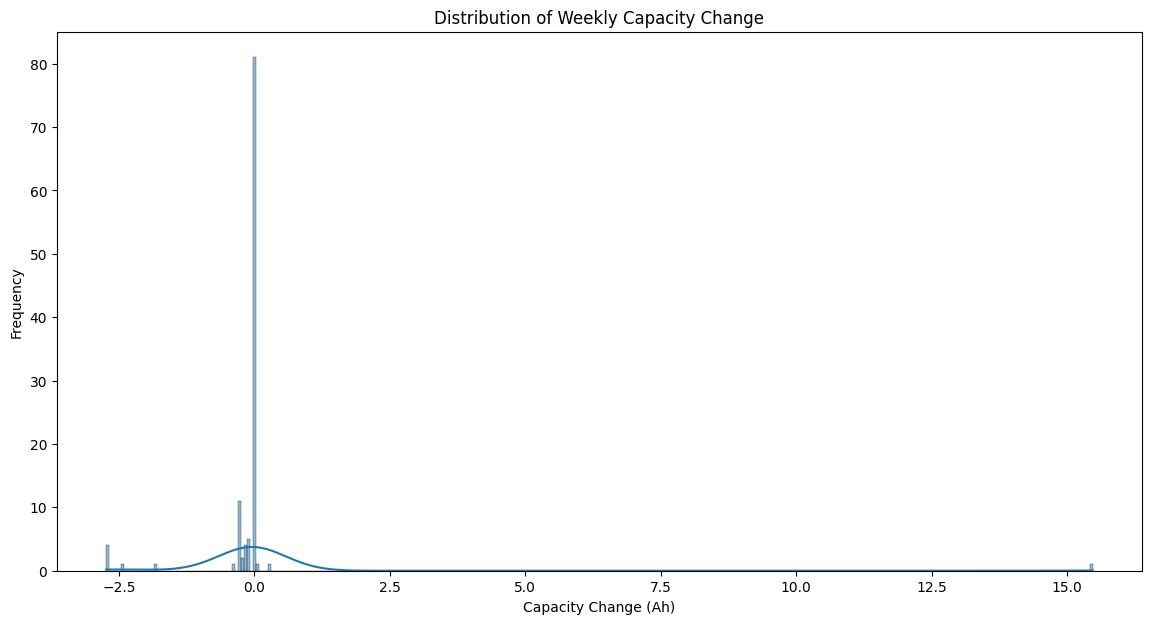

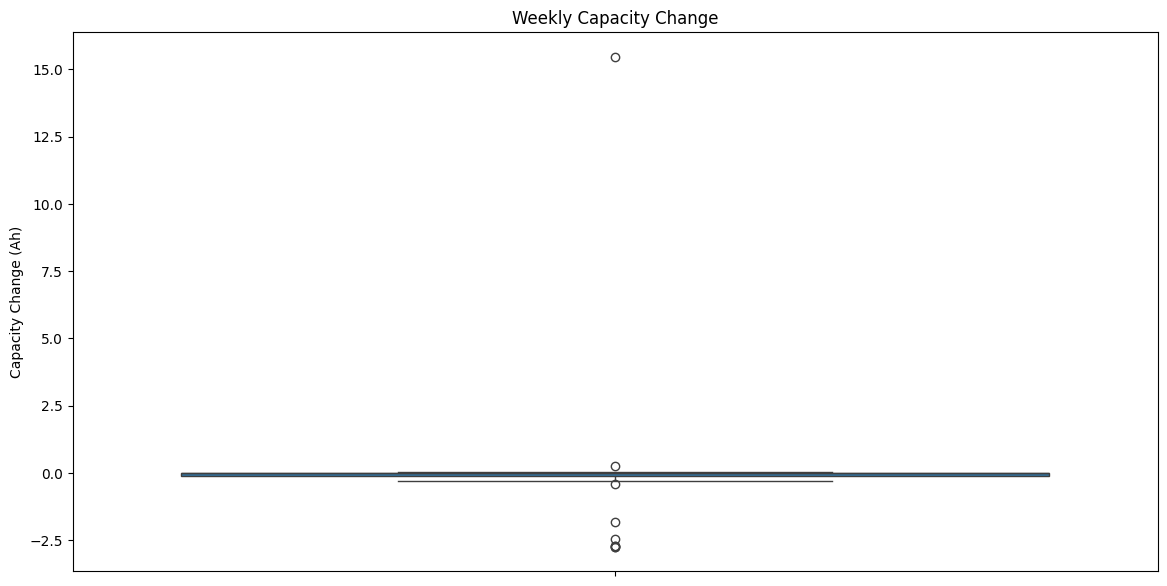

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 135.44368899540396
Slope: -0.05471749800361554

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

def draw_plot_t_capacity_trend(vin):

    weekly_capacity = weekly_ddfs[vin]

    # Week number
    X = np.arange(weekly_capacity.shape[0].compute()).reshape(-1, 1)

    y = weekly_capacity['capacity'].compute()

    # Perform linear regression
    reg = LinearRegression().fit(X, y)
    trend_line = reg.predict(X)

    # Step 4: Visualize the Results
    plt.figure(figsize=(14, 7))
    plt.plot(X, y, label='Weekly Max Capacity')
    plt.plot(X, trend_line, label='Trend Line', linestyle='--')
    plt.title('Weekly Max Capacity with Trend Line')
    plt.xlabel('Date')
    plt.ylabel('Available Capacity (Ah)')
    plt.legend()
    plt.show()

    # Show the weekly capacity change
    plt.figure(figsize=(14, 7))
    sns.histplot(weekly_capacity['capacity_change'], kde=True)
    plt.title('Distribution of Weekly Capacity Change')
    plt.xlabel('Capacity Change (Ah)')
    plt.ylabel('Frequency')
    plt.show()

    # Box plot of weekly capacity change
    plt.figure(figsize=(14, 7))
    sns.boxplot(y=weekly_capacity['capacity_change'])
    plt.title('Weekly Capacity Change')
    plt.ylabel('Capacity Change (Ah)')
    plt.show()

    # Textual Outputs
    # Summary statistics for weekly_capacity and weekly_capacity_change
    print("Summary Statistics for Weekly Max Capacity:")
    print(weekly_capacity.describe())


    # Linear Regression Coefficients
    print("\nLinear Regression Coefficients:")
    print(f"Intercept: {reg.intercept_}")
    print(f"Slope: {reg.coef_[0]}")

    # Textual interpretation of the trend
    print("\nTrend Interpretation:")
    if reg.coef_[0] > 0:
        print("The trend line indicates an increasing trend in weekly max capacity over time.")
    else:
        print("The trend line indicates a decreasing trend in weekly max capacity over time.")

    # # Monthly summaries
    # monthly_summary = weekly_capacity.resample('M').agg(['mean', 'max', 'min', 'std'])
    # print("\nMonthly Summary for Weekly Max Capacity:")
    # print(monthly_summary)

    # monthly_change_summary = weekly_capacity_change.resample('M').agg(['mean', 'max', 'min', 'std'])
    # print("\nMonthly Summary for Weekly Capacity Change:")
    # print(monthly_change_summary)


for i in range(5):
    draw_plot_t_capacity_trend(vin=i)

In [ ]:
print(data2.dtypes)

record_time                 datetime64[ns]
soc                                float32
pack_voltage (V)                   float32
charge_current (A)                 float32
max_cell_voltage (V)               float32
min_cell_voltage (V)               float32
max_temperature (℃)                  int32
min_temperature (℃)                  int32
available_energy (kw)              float32
available_capacity (Ah)            float32
time_diff                          float64
new_session                          int64
charging_type              string[pyarrow]
dtype: object


In [ ]:
charging_summary = data.groupby('charging_type')['charge_current (A)'].agg(['count', 'mean', 'std', 'min', 'max']).compute()
print(charging_summary)

                count       mean        std        min  max
charging_type                                              
DC             606987 -54.822947  16.418465 -86.600014  0.0
AC              98824 -28.948019   8.544945 -40.000000  0.0


# Step 6: Frequency Counts

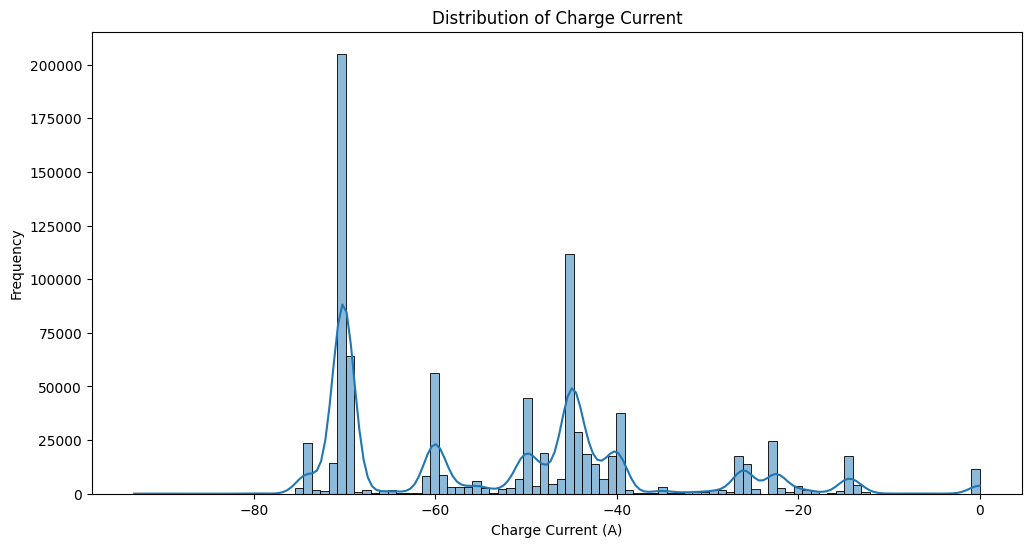

In [ ]:
computed_data = data.compute()

plt.figure(figsize=(12, 6))
sns.histplot(computed_data['charge_current (A)'], bins=100, kde=True)
plt.title('Distribution of Charge Current')
plt.xlabel('Charge Current (A)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(computed_data['charge_current (A)'].describe())

count    854591.000000
mean        -52.744633
std          17.399082
min         -93.200012
25%         -70.000000
50%         -50.200008
75%         -44.000000
max           0.000000
Name: charge_current (A), dtype: float64


In [ ]:
charging_type_counts = computed_data['charging_type'].value_counts()
print(charging_type_counts)

charging_type
DC    749752
AC    104839
Name: count, dtype: int64[pyarrow]


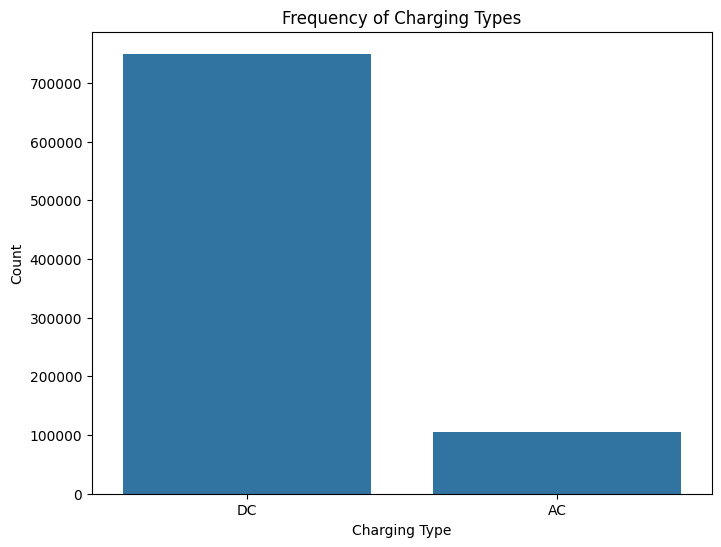

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=computed_data, x='charging_type')
plt.title('Frequency of Charging Types')
plt.xlabel('Charging Type')
plt.ylabel('Count')
plt.show()

# Step 7: Histograms/Box Plots

In [ ]:
print(data.head())

print(data.dtypes)

          record_time        soc  pack_voltage (V)  charge_current (A)  \
0 2019-07-26 20:02:35  27.200001        328.200012          -52.200008   
1 2019-07-26 20:02:43  27.600000        328.500000          -52.200008   
2 2019-07-26 20:02:51  27.600000        328.600006          -52.200008   
3 2019-07-26 20:02:59  27.600000        328.600006          -52.200008   
4 2019-07-26 20:03:07  27.600000        328.799988          -52.200008   

   max_cell_voltage (V)  min_cell_voltage (V)  max_temperature (℃)  \
0                 3.656                 3.640                   41   
1                 3.663                 3.645                   41   
2                 3.665                 3.647                   41   
3                 3.666                 3.649                   41   
4                 3.666                 3.649                   41   

   min_temperature (℃)  available_energy (kw)  available_capacity (Ah)  \
0                   38                  12.40               

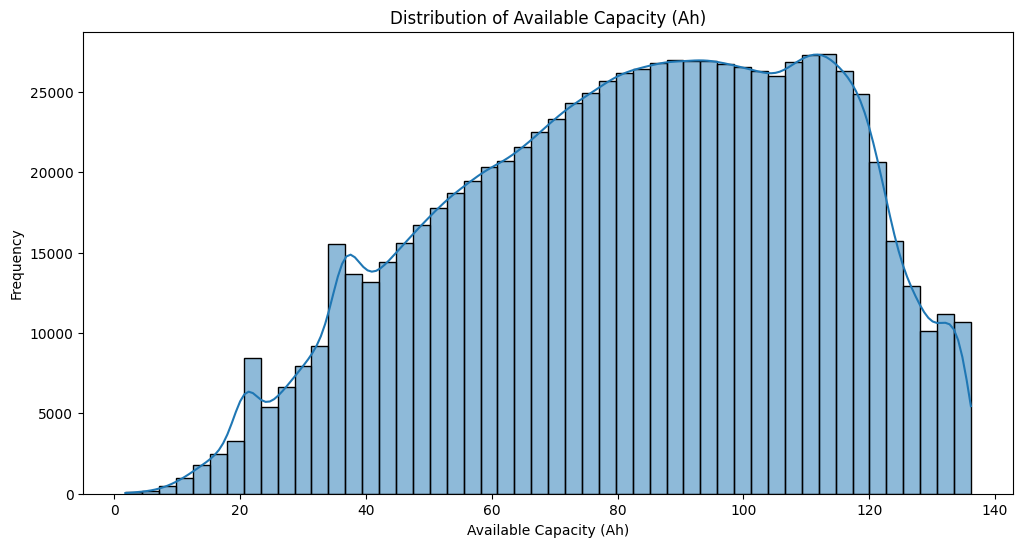

In [ ]:
# Histogram for Battery Lifespan (available_capacity (Ah))
plt.figure(figsize=(12, 6))
sns.histplot(computed_data['available_capacity (Ah)'], bins=50, kde=True)
plt.title('Distribution of Available Capacity (Ah)')
plt.xlabel('Available Capacity (Ah)')
plt.ylabel('Frequency')
plt.show()

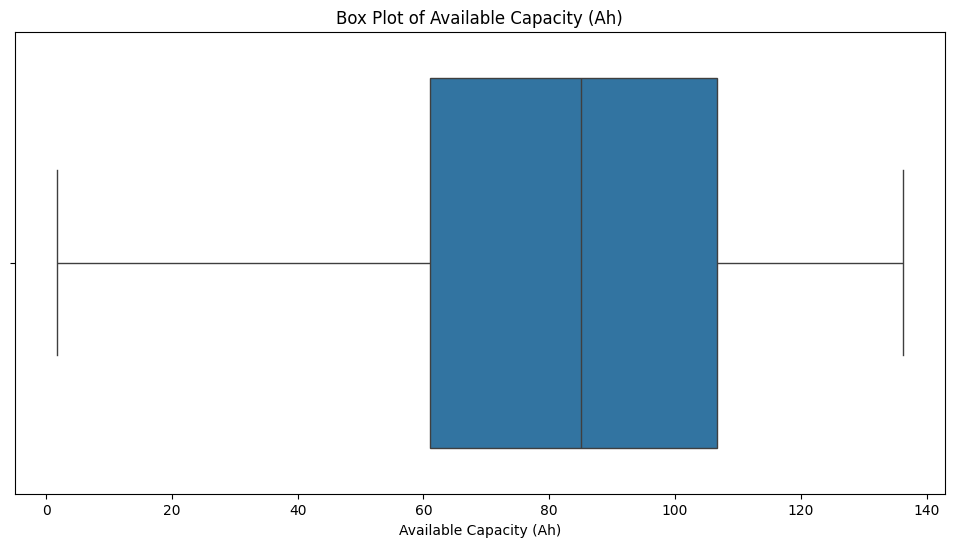

In [ ]:
# Box Plot for Battery Lifespan (available_capacity (Ah))
plt.figure(figsize=(12, 6))
sns.boxplot(x=computed_data['available_capacity (Ah)'])
plt.title('Box Plot of Available Capacity (Ah)')
plt.xlabel('Available Capacity (Ah)')
plt.show()

           duration
count   1620.000000
mean    4709.481481
std     2656.044005
min       30.000000
25%     3229.750000
50%     4424.500000
75%     5675.250000
max    44271.000000


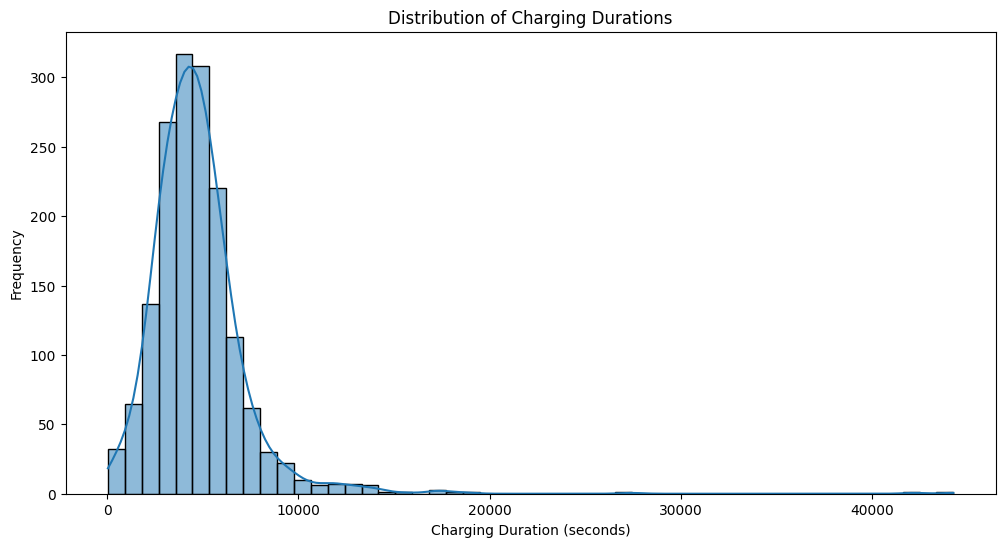

In [ ]:
# Charging Duration Calculation 
charging_duration = data.copy()
charging_duration = charging_duration.set_index('record_time')
session_duration = charging_duration.groupby('new_session').apply(lambda x: (x.index[-1] - x.index[0]).total_seconds(), meta=('duration', 'float64')).compute()

# Create a DataFrame for better visualization
session_duration_df = pd.DataFrame(session_duration, columns=['duration'])

# Summary statistics of charging durations
print(session_duration_df.describe())

# Visualize the distribution of charging durations
plt.figure(figsize=(12, 6))
sns.histplot(session_duration_df['duration'], bins=50, kde=True)
plt.title('Distribution of Charging Durations')
plt.xlabel('Charging Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

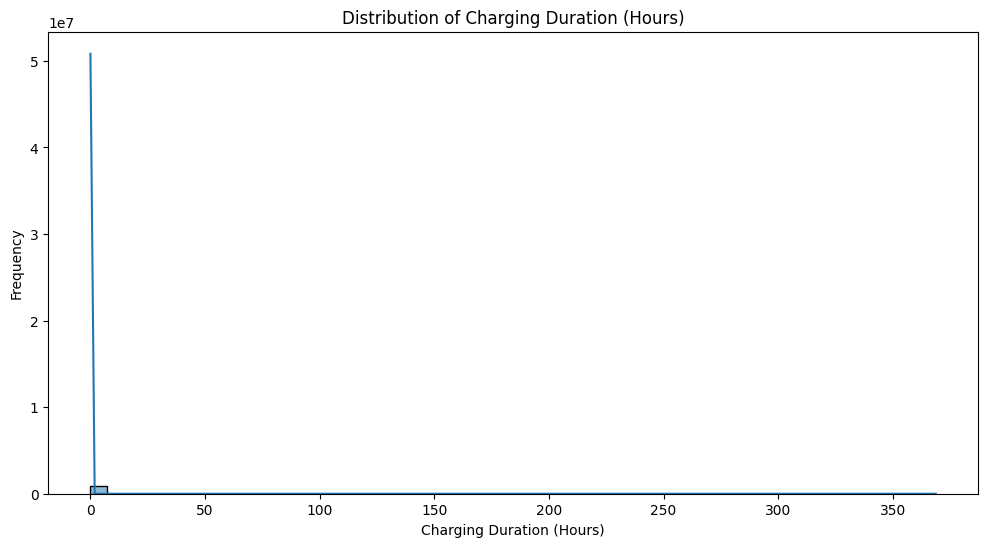

In [ ]:
# Histogram for charging_duration
plt.figure(figsize=(12, 6))
sns.histplot(computed_data['charging_duration'], bins=50, kde=True)
plt.title('Distribution of Charging Duration (Hours)')
plt.xlabel('Charging Duration (Hours)')
plt.ylabel('Frequency')
plt.show()

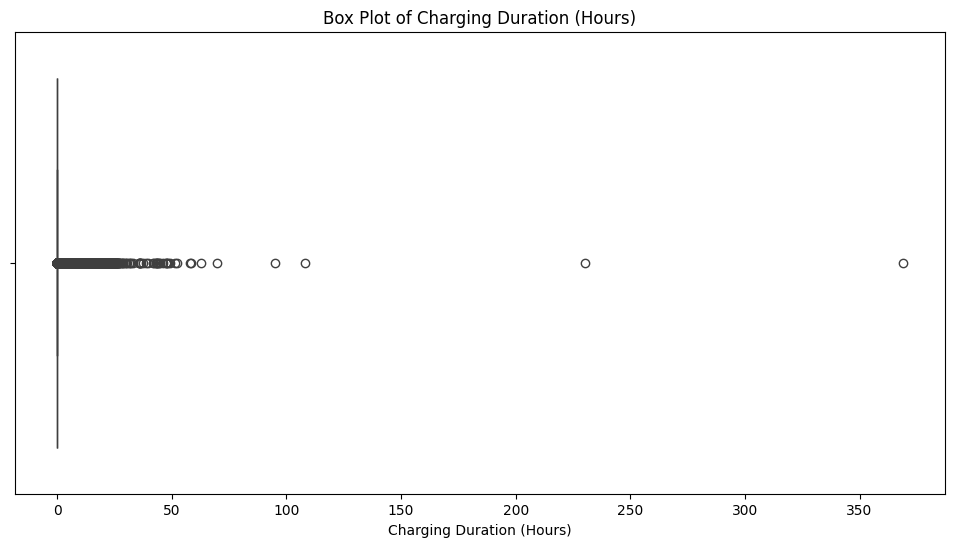

In [ ]:
# Box plot for charging_duration
plt.figure(figsize=(12, 6))
sns.boxplot(x=computed_data['charging_duration'])
plt.title('Box Plot of Charging Duration (Hours)')
plt.xlabel('Charging Duration (Hours)')
plt.show()

In [ ]:
# Filtering data for reasonable charging duration
# Filtering data for reasonable charging duration

session_duration_df.reset_index(inplace=True)

computed_data = computed_data.merge(session_duration_df, left_on='new_session', right_on='new_session', how='left')

max_duration_seconds = 24 * 3600  
data_cleaned = computed_data[computed_data['duration'] <= max_duration_seconds]


print(data_cleaned['duration'].describe())
data_cleaned['charging_duration'] = data_cleaned['duration']

NameError: name 'computed_data' is not defined

In [ ]:
print("Columns in the cleaned data:", data_cleaned.columns)
print(data_cleaned.head())

Columns in the cleaned data: Index(['record_time', 'soc', 'pack_voltage (V)', 'charge_current (A)',
       'max_cell_voltage (V)', 'min_cell_voltage (V)', 'max_temperature (℃)',
       'min_temperature (℃)', 'available_energy (kw)',
       'available_capacity (Ah)', 'time_diff', 'new_session', 'charging_type',
       'charging_duration'],
      dtype='object')
          record_time   soc  pack_voltage (V)  charge_current (A)  \
1 2019-07-26 20:02:43  27.6        328.500000          -52.200008   
2 2019-07-26 20:02:51  27.6        328.600006          -52.200008   
3 2019-07-26 20:02:59  27.6        328.600006          -52.200008   
4 2019-07-26 20:03:07  27.6        328.799988          -52.200008   
5 2019-07-26 20:03:15  28.0        328.799988          -52.200008   

   max_cell_voltage (V)  min_cell_voltage (V)  max_temperature (℃)  \
1                 3.663                 3.645                   41   
2                 3.665                 3.647                   41   
3           

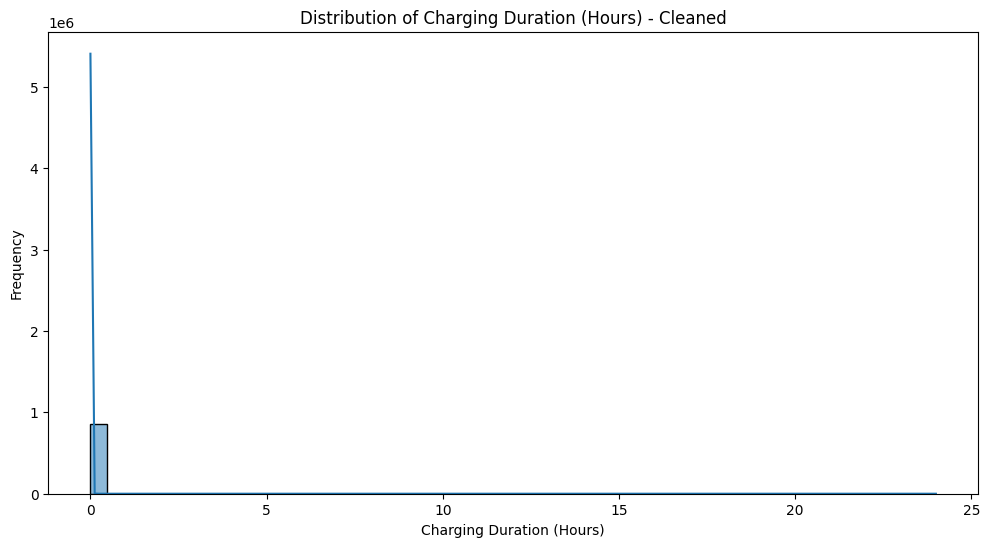

In [ ]:
# Histogram for cleaned charging duration
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned['charging_duration'], bins=50, kde=True)
plt.title('Distribution of Charging Duration (Hours) - Cleaned')
plt.xlabel('Charging Duration (Hours)')
plt.ylabel('Frequency')
plt.show()

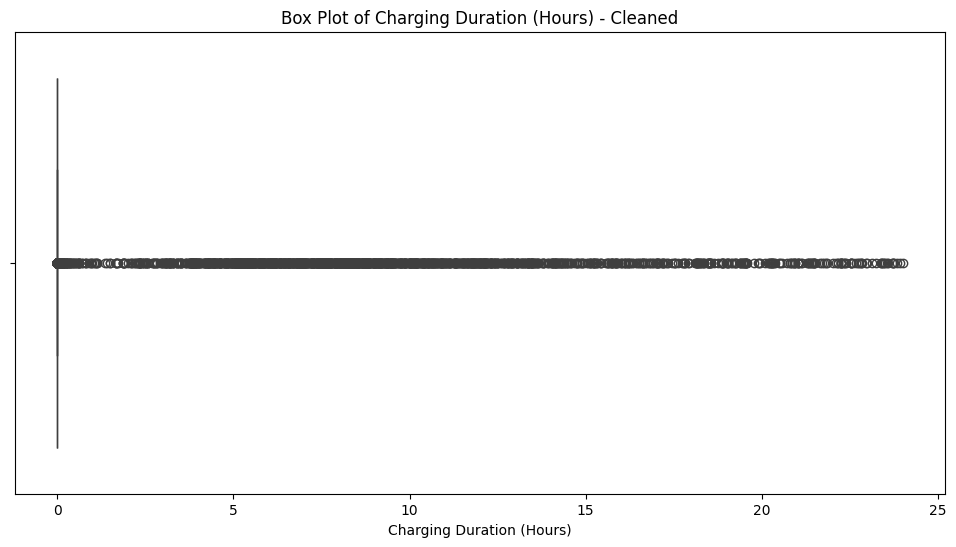

In [ ]:
# Box plot for cleaned charging duration
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_cleaned['charging_duration'])
plt.title('Box Plot of Charging Duration (Hours) - Cleaned')
plt.xlabel('Charging Duration (Hours)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


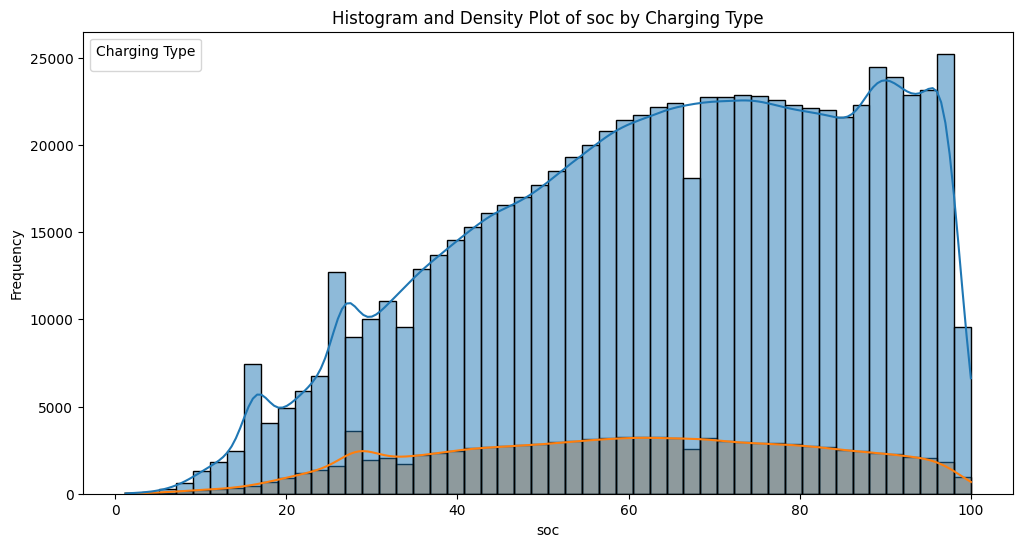

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


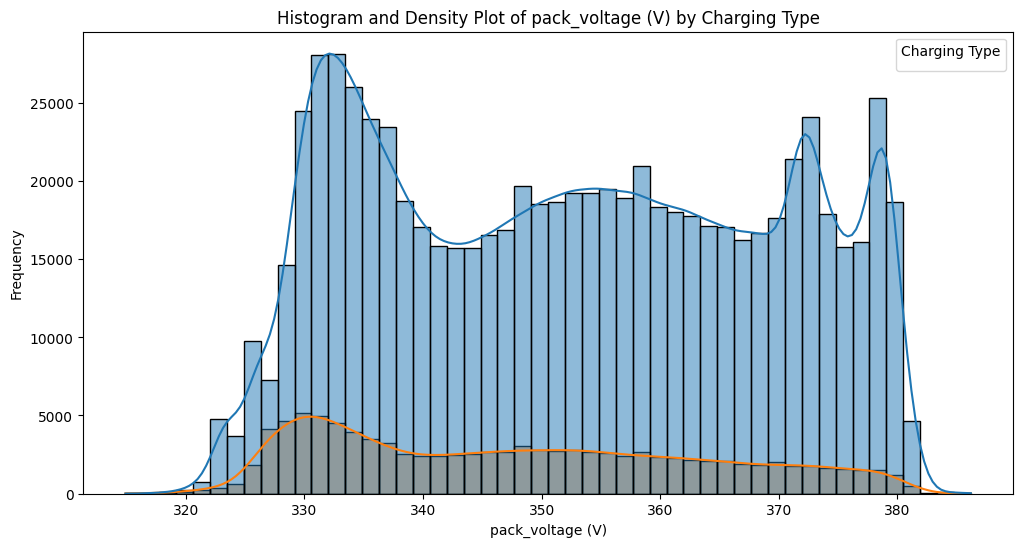

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


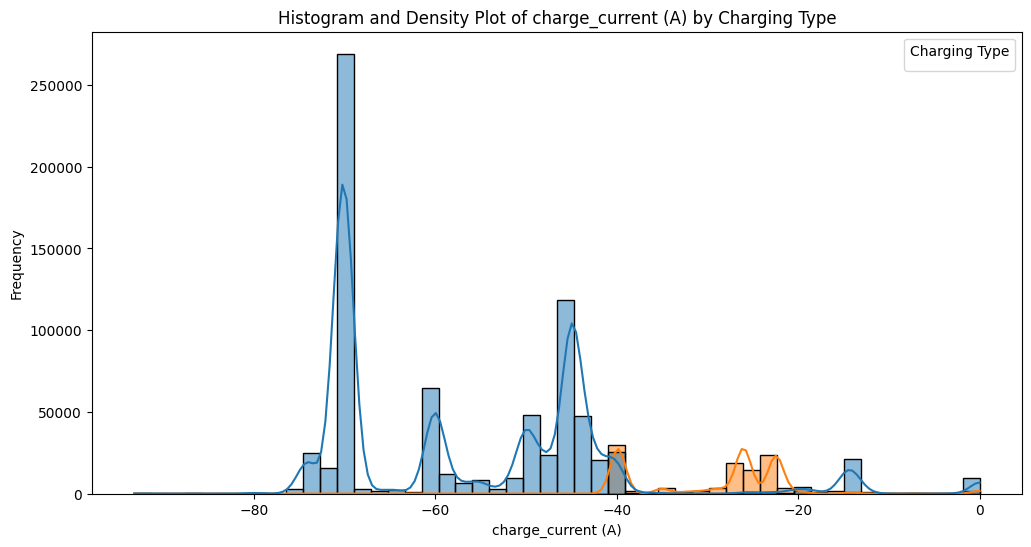

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


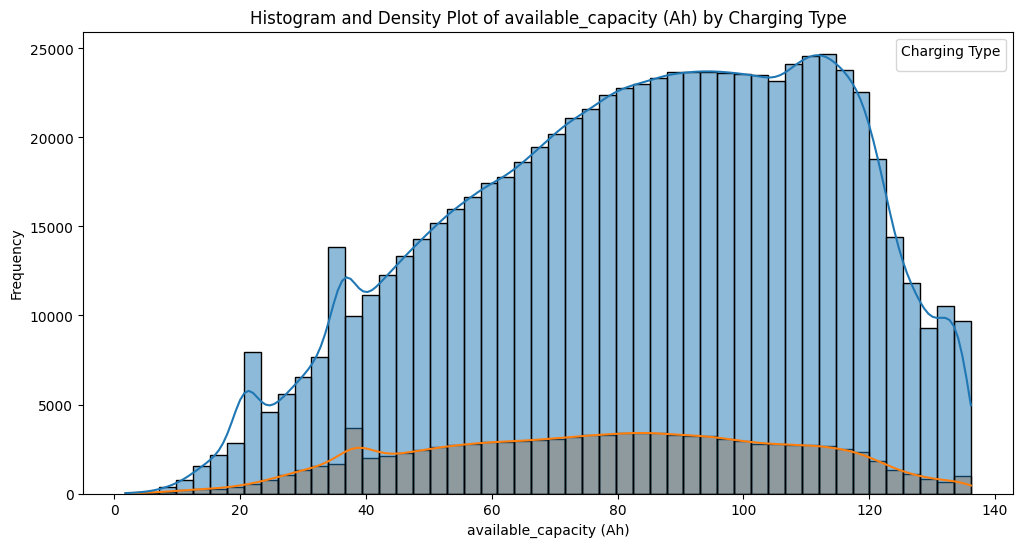

In [ ]:
# Histograms and Density Plots by Charging Type
for column in ['soc', 'pack_voltage (V)', 'charge_current (A)', 'available_capacity (Ah)']:
    plt.figure(figsize=(12, 6))
    sns.histplot(data_cleaned, x=column, hue='charging_type', kde=True, bins=50)
    plt.title(f'Histogram and Density Plot of {column} by Charging Type')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(title='Charging Type')
    plt.show()

In [ ]:
# Since the charge_current too dense on the right, only plot -100 to 10 using this block. 
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned, x='charge_current (A)', hue='charging_type', kde=True, bins=50)
plt.title('Histogram and Density Plot of charge_current (A) by Charging Type')
plt.xlabel('charge_current (A)')
plt.ylabel('Frequency')
plt.legend(title='Charging Type')
plt.xlim(-100, 10)  # Adjust the range as per your data
plt.show()


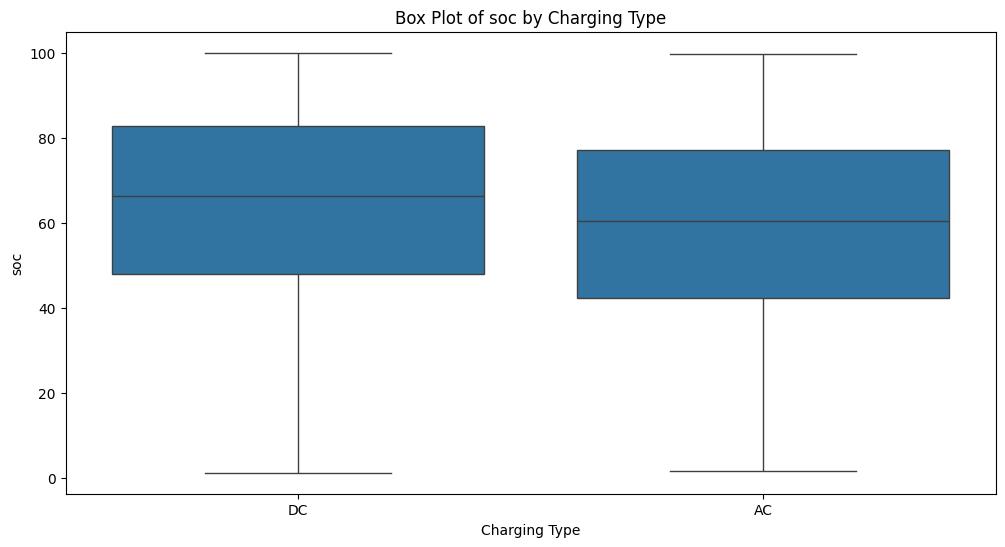

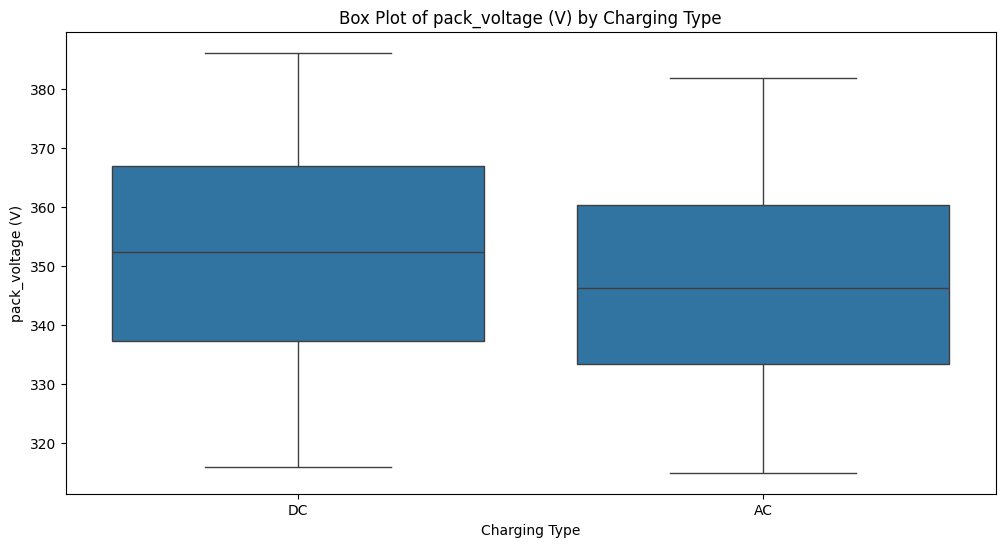

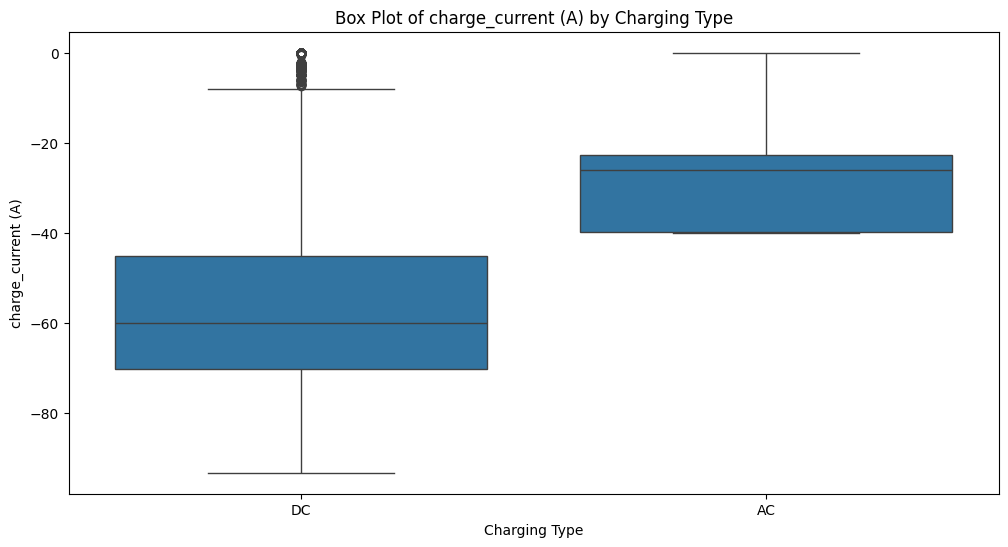

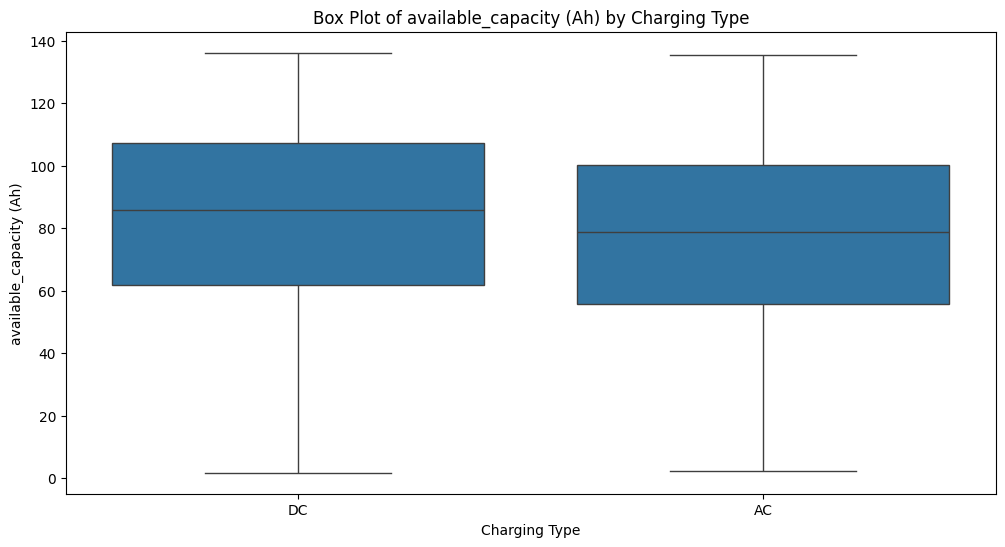

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned, x='charge_current (A)', hue='charging_type', kde=True, bins=50)
plt.title('Histogram and Density Plot of charge_current (A) by Charging Type')
plt.xlabel('charge_current (A)')
plt.ylabel('Frequency')
plt.legend(title='Charging Type')
plt.xlim(-100, 10)  # Adjust the range as per your data
plt.show()
# Box Plots by Charging Type
for column in ['soc', 'pack_voltage (V)', 'charge_current (A)', 'available_capacity (Ah)']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='charging_type', y=column, data=data_cleaned)
    plt.title(f'Box Plot of {column} by Charging Type')
    plt.xlabel('Charging Type')
    plt.ylabel(column)
    plt.show()

# Step 8: Scatter Plots

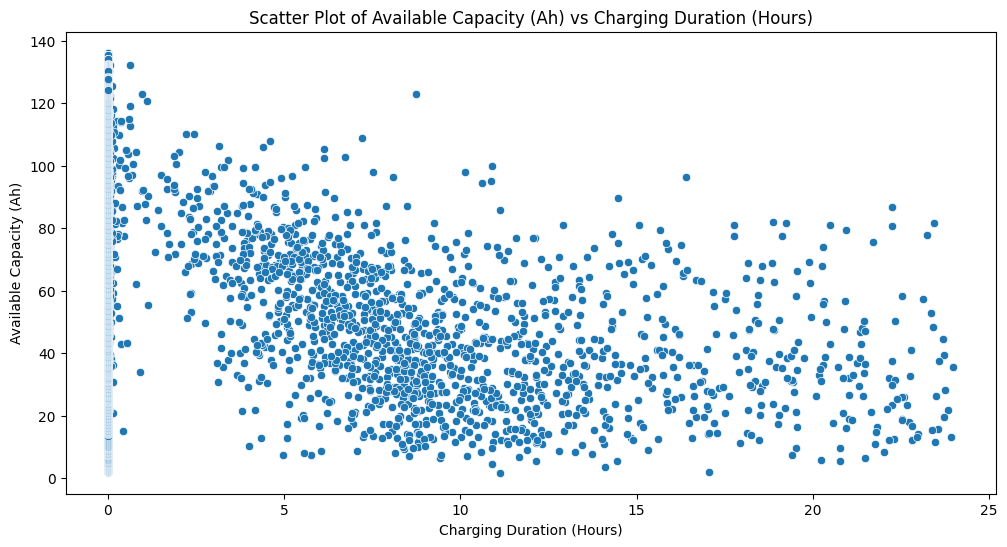

In [ ]:
# Scatter plot of available capacity against charging duration
plt.figure(figsize=(12, 6))
sns.scatterplot(x='charging_duration', y='available_capacity (Ah)', data=data_cleaned)
plt.title('Scatter Plot of Available Capacity (Ah) vs Charging Duration (Hours)')
plt.xlabel('Charging Duration (Hours)')
plt.ylabel('Available Capacity (Ah)')
plt.show()

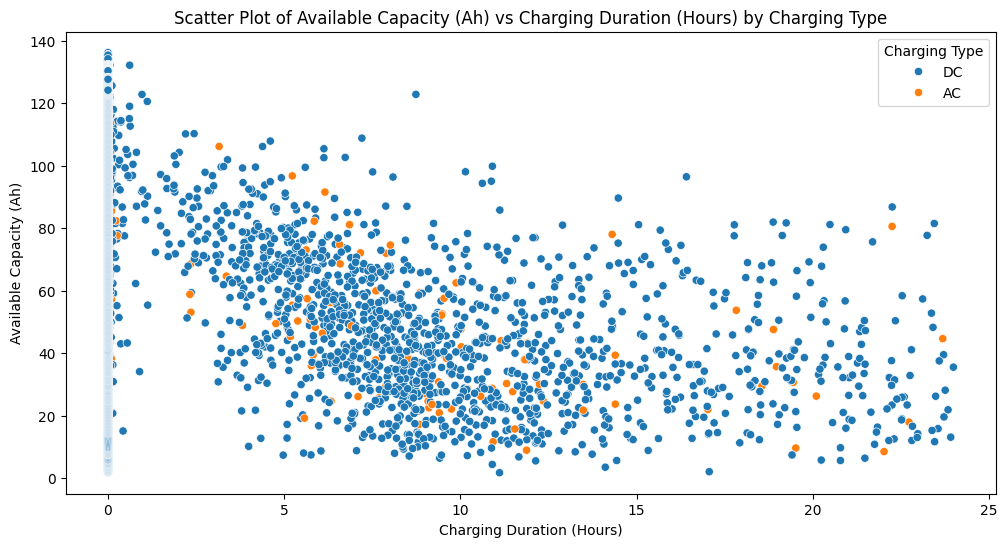

In [ ]:
# Scatter plot of available capacity against charging duration, differentiated by charging type
plt.figure(figsize=(12, 6))
sns.scatterplot(x='charging_duration', y='available_capacity (Ah)', hue='charging_type', data=data_cleaned)
plt.title('Scatter Plot of Available Capacity (Ah) vs Charging Duration (Hours) by Charging Type')
plt.xlabel('Charging Duration (Hours)')
plt.ylabel('Available Capacity (Ah)')
plt.legend(title='Charging Type')
plt.show()

# Step 9: Time Series Plots

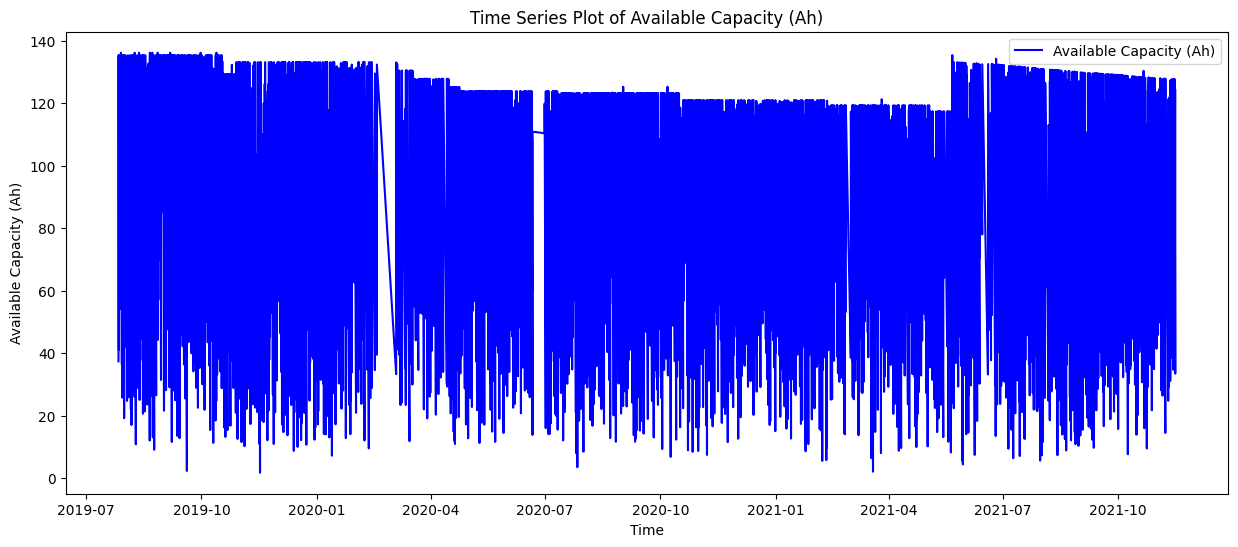

In [ ]:
data_cleaned.set_index('record_time', inplace=True)

# Time Series Plot of Available Capacity (Ah)
plt.figure(figsize=(15, 6))
plt.plot(data_cleaned.index, data_cleaned['available_capacity (Ah)'], label='Available Capacity (Ah)', color='blue')
plt.title('Time Series Plot of Available Capacity (Ah)')
plt.xlabel('Time')
plt.ylabel('Available Capacity (Ah)')
plt.legend()
plt.show()

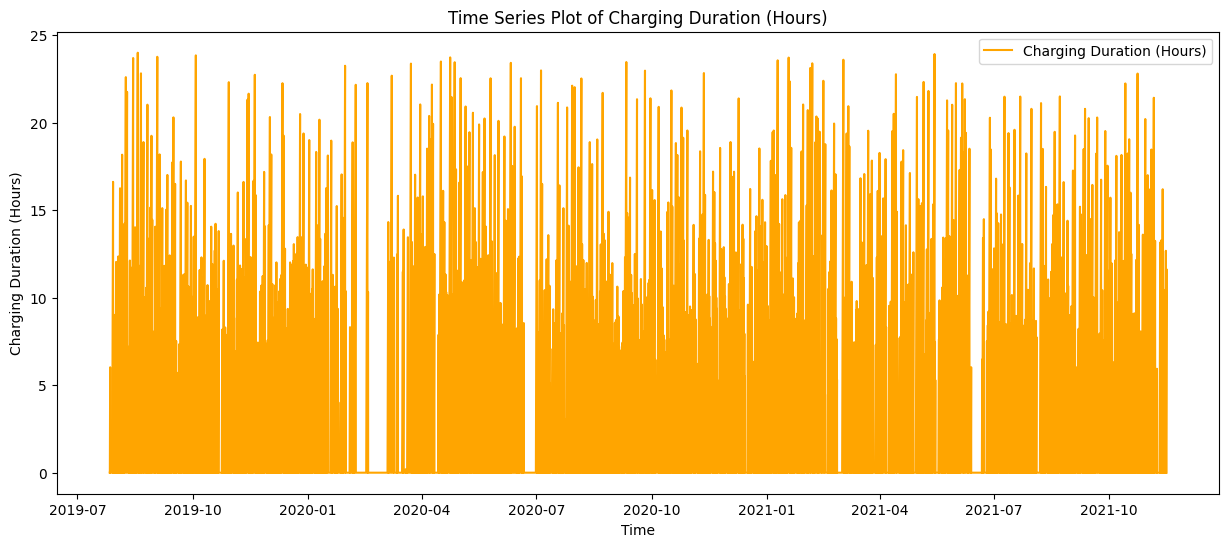

In [ ]:
# Time series plot of charging duration (Hours)
plt.figure(figsize=(15, 6))
plt.plot(data_cleaned.index, data_cleaned['charging_duration'], label='Charging Duration (Hours)', color='orange')
plt.title('Time Series Plot of Charging Duration (Hours)')
plt.xlabel('Time')
plt.ylabel('Charging Duration (Hours)')
plt.legend()
plt.show()

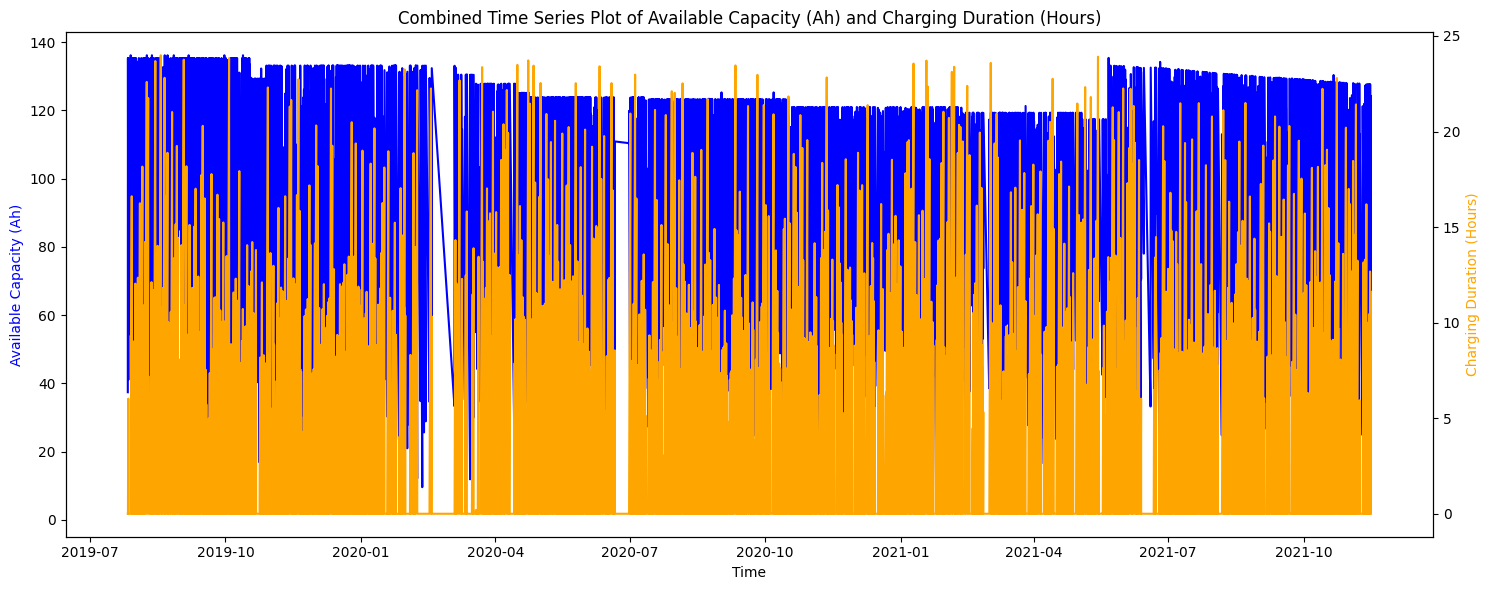

In [ ]:
# Combined time series plot
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data_cleaned.index, data_cleaned['available_capacity (Ah)'], label='Available Capacity (Ah)', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Available Capacity (Ah)', color='blue')

ax2 = ax1.twinx()
ax2.plot(data_cleaned.index, data_cleaned['charging_duration'], label='Charging Duration (Hours)', color='orange')
ax2.set_ylabel('Charging Duration (Hours)', color='orange')

plt.title('Combined Time Series Plot of Available Capacity (Ah) and Charging Duration (Hours)')
fig.tight_layout()
plt.show()

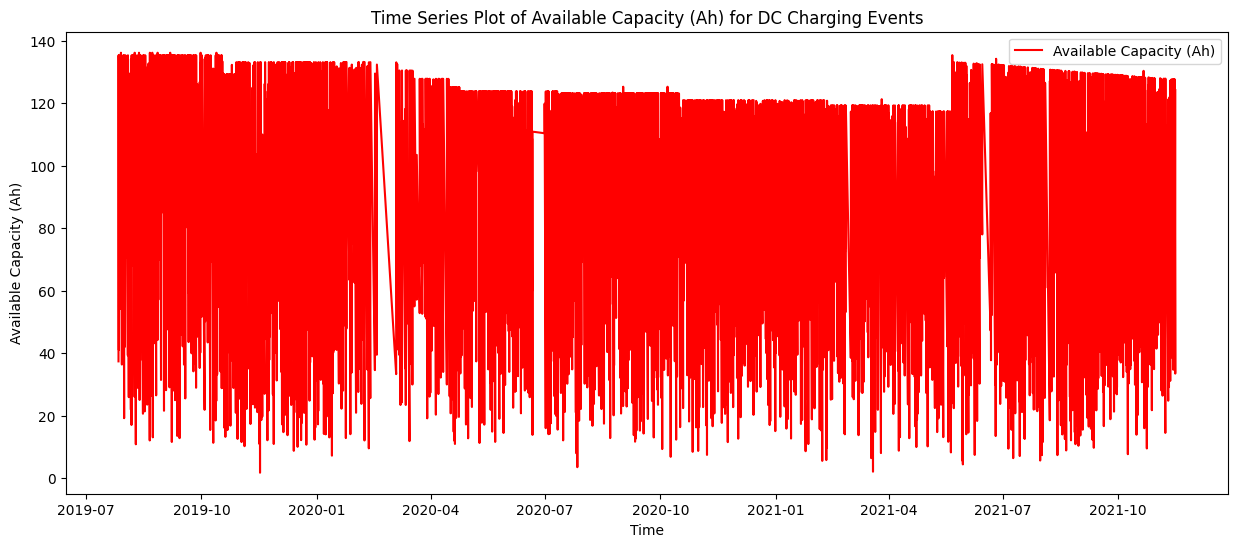

In [ ]:
# Time Series Plot for DC Charging Events
dc_charging_data = data_cleaned[data_cleaned['charging_type'] == 'DC']
plt.figure(figsize=(15, 6))
plt.plot(dc_charging_data.index, dc_charging_data['available_capacity (Ah)'], label='Available Capacity (Ah)', color='red')
plt.title('Time Series Plot of Available Capacity (Ah) for DC Charging Events')
plt.xlabel('Time')
plt.ylabel('Available Capacity (Ah)')
plt.legend()
plt.show()

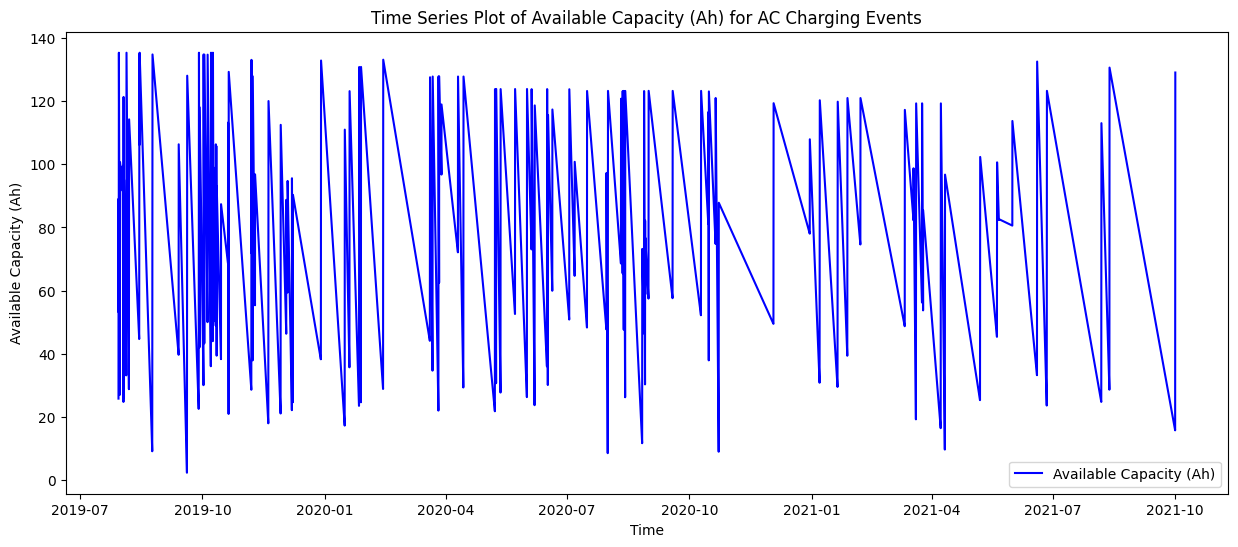

In [ ]:
# Time Series Plot for AC Charging Events
ac_charging_data = data_cleaned[data_cleaned['charging_type'] == 'AC']
plt.figure(figsize=(15, 6))
plt.plot(ac_charging_data.index, ac_charging_data['available_capacity (Ah)'], label='Available Capacity (Ah)', color='blue')
plt.title('Time Series Plot of Available Capacity (Ah) for AC Charging Events')
plt.xlabel('Time')
plt.ylabel('Available Capacity (Ah)')
plt.legend()
plt.show()

# Step 10: Correlation Matrix

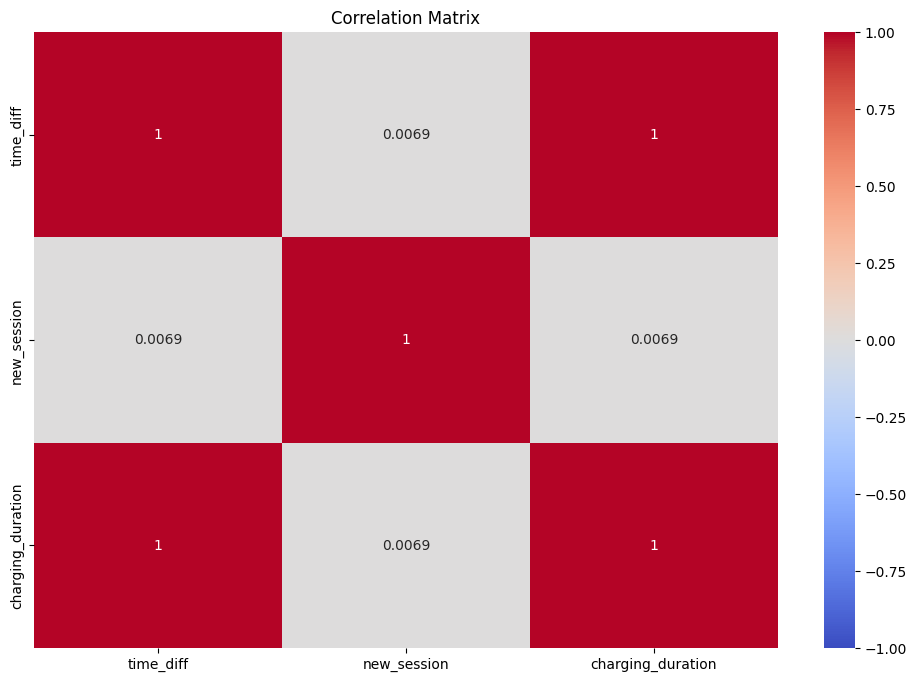

In [ ]:
# Correlation Matrix
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Step 11: Propensity Score Matching

In [ ]:
matching_columns = ['soc', 'pack_voltage (V)', 'charge_current (A)', 'max_temperature (℃)', 'min_temperature (℃)', 'available_energy (kw)']
data_cleaned['treatment'] = data_cleaned['charging_type'].apply(lambda x: 1 if x == 'DC' else 0)

X = data_cleaned[matching_columns]
y = data_cleaned['treatment']
log_reg = LogisticRegression()
log_reg.fit(X, y)
propensity_scores = log_reg.predict_proba(X)[:, 1]

data_cleaned['propensity_score'] = propensity_scores

treated = data_cleaned[data_cleaned['treatment'] == 1]
control = data_cleaned[data_cleaned['treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]
matched_data = pd.concat([treated, matched_control])

for column in matching_columns:
    print(f"Mean of {column} in treated: {treated[column].mean()}")
    print(f"Mean of {column} in control: {matched_control[column].mean()}")

treated_outcome = matched_data[matched_data['treatment'] == 1]['available_capacity (Ah)']
control_outcome = matched_data[matched_data['treatment'] == 0]['available_capacity (Ah)']
treatment_effect = treated_outcome.mean() - control_outcome.mean()
print(f"Estimated Treatment Effect: {treatment_effect}")

/tmp/ipykernel_369/1106411612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['treatment'] = data_cleaned['charging_type'].apply(lambda x: 1 if x == 'DC' else 0)
/tmp/ipykernel_369/1106411612.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['propensity_score'] = propensity_scores
Mean of soc in treated: 64.26937103271484
Mean of soc in control: 87.71553039550781
Mean of pack_voltage (V) in treated: 352.4942321777344
Mean of pack_voltage (V) in control: 371.6752624511719
Mea

# Step 12: Difference-in-Differences (DiD)

In [ ]:
data_cleaned.reset_index(inplace=True)
data_cleaned['record_time'] = pd.to_datetime(data_cleaned['record_time'], errors='coerce')
data_cleaned['period'] = data_cleaned['record_time'].apply(lambda x: 'pre' if x < pd.Timestamp('2020-01-01') else 'post')
data_cleaned['treatment'] = data_cleaned['charging_type'].apply(lambda x: 1 if x == 'DC' else 0)
data_cleaned['treatment_period'] = data_cleaned['treatment'] * (data_cleaned['period'] == 'post').astype(int)

formula = 'Q("available_capacity (Ah)") ~ treatment + period + treatment_period + soc + Q("pack_voltage (V)") + Q("charge_current (A)") + Q("max_temperature (℃)") + Q("min_temperature (℃)")'
model = smf.ols(formula, data=data_cleaned).fit()

print(model.summary())

treatment_effect = model.params['treatment_period']
print(f"Estimated Treatment Effect (DiD): {treatment_effect}")

/tmp/ipykernel_369/3914347432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['record_time'] = pd.to_datetime(data_cleaned['record_time'], errors='coerce')
/tmp/ipykernel_369/3914347432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['period'] = data_cleaned['record_time'].apply(lambda x: 'pre' if x < pd.Timestamp('2020-01-01') else 'post')
/tmp/ipykernel_369/3914347432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

# Statistical methods
Step 13: Regression Analysis

In [ ]:
data_cleaned['charging_type_numeric'] = data_cleaned['charging_type'].apply(lambda x: 1 if x == 'DC' else 0)

X = data_cleaned[['charging_type_numeric', 'charging_duration', 'soc', 'pack_voltage (V)', 'charge_current (A)', 'max_temperature (℃)', 'min_temperature (℃)']]
X = sm.add_constant(X)  
y = data_cleaned['available_capacity (Ah)']

model = sm.OLS(y, X).fit()

print(model.summary())

/tmp/ipykernel_369/2126794251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['charging_type_numeric'] = data_cleaned['charging_type'].apply(lambda x: 1 if x == 'DC' else 0)
                               OLS Regression Results                              
Dep. Variable:     available_capacity (Ah)   R-squared:                       0.984
Model:                                 OLS   Adj. R-squared:                  0.984
Method:                      Least Squares   F-statistic:                 7.638e+06
Date:                     Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                             19:30:08   Log-Likelihood:            -2.3160e+06
No. Observations:                   854483   AIC:            

In [ ]:
formula = 'Q("available_capacity (Ah)") ~ treatment + Q("charging_duration") + soc + Q("pack_voltage (V)") + Q("charge_current (A)") + Q("max_temperature (℃)") + Q("min_temperature (℃)")'

model = smf.ols(formula, data=data_cleaned).fit()

print(model.summary())

coefficients = model.params
p_values = model.pvalues
r_squared = model.rsquared

print(f"Coefficients:\n{coefficients}")
print(f"P-values:\n{p_values}")
print(f"R-squared: {r_squared}")

                                 OLS Regression Results                                 
Dep. Variable:     Q("available_capacity (Ah)")   R-squared:                       0.984
Model:                                      OLS   Adj. R-squared:                  0.984
Method:                           Least Squares   F-statistic:                 7.638e+06
Date:                          Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                                  19:30:09   Log-Likelihood:            -2.3160e+06
No. Observations:                        854483   AIC:                         4.632e+06
Df Residuals:                            854475   BIC:                         4.632e+06
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------

# Step 14: Time Series Analysis

In [ ]:
data_cleaned['record_time'] = pd.to_datetime(data_cleaned['record_time'], errors='coerce')
data_cleaned.set_index('record_time', inplace=True)
daily_data = data_cleaned['available_capacity (Ah)'].resample('D').mean()

/tmp/ipykernel_369/878188243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['record_time'] = pd.to_datetime(data_cleaned['record_time'], errors='coerce')


In [ ]:
# Decomposition
decomposition = seasonal_decompose(daily_data, model='additive')
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

ValueError: This function does not handle missing values

In [ ]:
# ADF test
result = adfuller(daily_data.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

In [ ]:
# ACF and PACF plots
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(daily_data.dropna(), lags=50, ax=ax[0])
plot_pacf(daily_data.dropna(), lags=50, ax=ax[1])
plt.show()

In [ ]:
# ARIMA model
model = sm.tsa.ARIMA(daily_data.dropna(), order=(5, 1, 0))  # Adjust the order (p, d, q) as needed
results = model.fit()
print(results.summary())

# Diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast
forecast = results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 8))
plt.plot(daily_data, label='Observed')
plt.plot(forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Available Capacity (Ah)')
plt.legend()
plt.show()

Interpretation of the Data
Summary Statistics for Weekly Max Capacity:
Count: There are 120 weekly observations of the maximum battery capacity.
Mean: The average weekly maximum capacity is approximately 127.47 Ah.
Standard Deviation (std): The standard deviation is about 5.68 Ah, indicating some variability in the weekly maximum capacities.
Minimum (min): The lowest weekly maximum capacity recorded is approximately 117.42 Ah.
25th Percentile (25%): 25% of the weekly maximum capacities are below approximately 122.76 Ah.
Median (50%): The median weekly maximum capacity is approximately 127.83 Ah.
75th Percentile (75%): 75% of the weekly maximum capacities are below approximately 133.10 Ah.
Maximum (max): The highest weekly maximum capacity recorded is approximately 136.16 Ah.
Summary Statistics for Weekly Capacity Change:
Count: There are 119 observations of weekly capacity change.
Mean: The average change in weekly capacity is approximately -0.071 Ah, indicating a slight overall decrease.
Standard Deviation (std): The standard deviation is about 1.88 Ah, indicating variability in weekly capacity changes.
Minimum (min): The largest negative weekly change recorded is approximately -3.06 Ah.
25th Percentile (25%): 25% of the weekly capacity changes are below approximately -0.25 Ah.
Median (50%): The median weekly capacity change is 0 Ah, suggesting that in many weeks, there is no change.
75th Percentile (75%): 75% of the weekly capacity changes are below 0 Ah.
Maximum (max): The largest positive weekly change recorded is approximately 17.97 Ah.


Linear Regression Coefficients:


Intercept: The intercept of the regression line is approximately 131.42 Ah. This represents the estimated weekly maximum capacity at the start of the dataset (week 0).


Slope: The slope of the regression line is approximately -0.066 Ah per week. This indicates that, on average, the weekly maximum capacity decreases by about 0.066 Ah each week.


Trend Interpretation:
The trend line in the plot shows a decreasing trend in the weekly maximum capacity over time, which aligns with the negative slope of the linear regression model. This suggests that the battery capacity is gradually declining each week.


Monthly Summary for Weekly Max Capacity:
2019-07: The highest average weekly capacity is recorded at 136.16 Ah, indicating that the battery was at its best performance at the beginning of the dataset.
2019-08 to 2019-10: The capacity gradually decreases, with the average max capacity falling from 135.95 Ah in August to 134.98 Ah in October.
2019-11 to 2020-03: The decline continues, with a slight anomaly in March 2020 where the capacity drops more significantly to 130.49 Ah.
2020-04 to 2021-01: The battery capacity continues to decrease steadily, with some months showing more significant drops, such as April 2020 (127.16 Ah) and January 2021 (120.99 Ah).
2021-05 to 2021-11: The capacity shows some recovery in May 2021 (124.91 Ah) but then decreases again, reaching 127.79 Ah by November 2021.


Monthly Summary for Weekly Capacity Change:
2019-08: The capacity change is neutral, indicating stable performance.
2019-09 to 2019-10: The capacity change becomes more negative, with a significant drop in October 2019 (-0.76 Ah).
2019-11 to 2020-03: There are fluctuations, but the trend is negative, with notable drops in March 2020 (-1.13 Ah).
2020-04 to 2020-07: The negative trend continues with significant drops, particularly in April 2020 (-0.67 Ah).
2020-08 to 2021-01: The capacity change stabilizes somewhat, with smaller fluctuations and even some positive changes.
2021-02 to 2021-11: The capacity changes show more variability, with a significant positive change in May 2021 (2.75 Ah), followed by a return to negative changes.


Key Insights:
Overall Decline: The data indicates a general decline in the battery's maximum capacity over time, with an average decrease of about 0.066 Ah per week.


Stability and Fluctuations: While there are periods of stability, there are also significant fluctuations, particularly around early 2021.


Negative Trends: The overall trend is negative, indicating that the battery capacity is decreasing over the period analyzed.


Monthly Variations: Monthly summaries show that while some months exhibit stable or slightly positive changes, the general trend is a decline in battery capacity.


In [ ]:
# import pandas as pd
# import dask.dataframe as dd
# from datetime import datetime, timedelta
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns


# sessions_by_week = data2.copy()
# # Assuming 'data2' is your DataFrame
# sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])

# # Group by 'new_session' to get the minimum 'record_time' for each session
# sessions_by_week = sessions_by_week.groupby('new_session').min().reset_index()

# # Select the desired columns
# sessions_by_week = sessions_by_week[['charging_type', 'record_time', 'new_session']]

# # Convert 'record_time' to datetime
# sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])

# # Set 'record_time' as the index
# sessions_by_week = sessions_by_week.set_index('record_time')

# # Compute the DataFrame to bring it into memory
# sessions_by_week = sessions_by_week.compute()

# # Resample by week and count the 'new_session' column grouped by 'charging_type'
# weekly_counts = sessions_by_week.groupby([pd.Grouper(freq='W'), 'charging_type']).new_session.count().unstack(fill_value=0)

# # Add weekly counts to the main DataFrame
# sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])
# sessions_by_week = sessions_by_week.set_index('record_time')

# # Compute the main DataFrame to bring it into memory
# df = sessions_by_week.compute()

# # Resample to get the maximum available capacity for each week
# weekly_capacity = df['available_capacity (Ah)'].resample('W').max().dropna()

# # Calculate weekly capacity change
# weekly_capacity_change = weekly_capacity.diff().dropna()

# # Combine the weekly counts and weekly capacity change into a single DataFrame
# weekly_data = weekly_counts.join(weekly_capacity_change.rename('capacity_change')).dropna()

# print(weekly_data.head())


# weekly_data.loc[['AC', 'DC']].plot(kind='bar')

In [ ]:
for ddf in ddf_list:
    print(ddf.head())
    weekly = compute_monthly_capacity_change(ddf, mode='W')
    sessions_result = compute_AC_DC_by_sessions(ddf, mode='W')

    plt.figure(figsize=(12, 6))
    sns.histplot(weekly['capacity_change'], bins=50, kde=True)
    plt.title('Distribution of Capacity Change by Week (Ah)')
    plt.xlabel('Capacity Change (Ah)')
    plt.ylabel('Frequency')
    plt.show()

          record_time        soc  pack_voltage (V)  charge_current (A)  \
0 2019-07-26 20:02:35  27.200001        328.200012          -52.200008   
1 2019-07-26 20:02:43  27.600000        328.500000          -52.200008   
2 2019-07-26 20:02:51  27.600000        328.600006          -52.200008   
3 2019-07-26 20:02:59  27.600000        328.600006          -52.200008   
4 2019-07-26 20:03:07  27.600000        328.799988          -52.200008   

   max_cell_voltage (V)  min_cell_voltage (V)  max_temperature (℃)  \
0                 3.656                 3.640                   41   
1                 3.663                 3.645                   41   
2                 3.665                 3.647                   41   
3                 3.666                 3.649                   41   
4                 3.666                 3.649                   41   

   min_temperature (℃)  available_energy (kw)  available_capacity (Ah)  \
0                   38                  12.40               

KeyError: "['charging_type'] not in index"

In [ ]:
# Prepare the data for linear regression


def get_joined(vin):
    monthly = weekly_ddfs[vin]
    sessions_result = sessions_results[vin]
    merged = monthly.merge(right=sessions_result, left_index=True, right_on='record_time')

    print(merged.max().compute())

    merged = merged.loc[merged['capacity_change'] < 10]

    merged = merged.assign(
        charging_count= merged['AC'] + merged['DC']
    )

    merged = merged.compute()
    return merged

def get_X_y(vin):
    merged = get_joined(vin)
    # columns = [ 'AC', 'DC']
    columns = [ 'charging_count']

    X = merged[columns]

    y = merged['capacity_change']  # Response variable: change in capacity

    # Convert to Pandas DataFrame
    X = X.values.reshape(-1, len(columns))
    y = y.values
    # print(X)
    return X, y

Xys = [ get_X_y(vin) for vin in range(20) ]

X = np.concatenate([X for (X, _) in Xys], axis=0)
y = np.concatenate([y for (_, y) in Xys])

# print(X)

# sorted_indices = np.argsort(X, axis=0).flatten()

# X = X[sorted_indices]
# y = y[sorted_indices]

# Perform linear regression
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Regression coefficients
intercept = reg.intercept_
coefficients = reg.coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

# # Visualize the results
# plt.figure(figsize=(14, 7))
# plt.scatter(X, y, label='Actual Capacity Change')
# plt.scatter(X, y_pred, label='Predicted Capacity Change', linestyle='--')

# # plt.bar(merged.index, merged['DC'], label='DC')
# # plt.bar(merged.index, merged['AC'], label='AC')
# plt.title('Weekly Capacity Change: Actual vs Predicted')
# plt.xlabel('Date')
# plt.ylabel('Capacity Change (Ah)')
# plt.legend()
# plt.show()

# Show the regression summary
import statsmodels.api as sm

# Adding a constant for the intercept
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())





capacity_change     16.173744
capacity           136.495636
AC                   7.000000
DC                  20.000000
dtype: float64
capacity_change     12.152016
capacity           136.495636
AC                   4.000000
DC                  21.000000
dtype: float64
capacity_change     17.190781
capacity           136.500000
AC                   5.000000
DC                  20.000000
dtype: float64
capacity_change     14.801498
capacity           136.495636
AC                   4.000000
DC                  20.000000
dtype: float64
capacity_change     15.473518
capacity           136.706833
AC                   8.000000
DC                  20.000000
dtype: float64
capacity_change     14.701187
capacity           136.508804
AC                   7.000000
DC                  23.000000
dtype: float64
capacity_change     16.748947
capacity           136.508804
AC                   8.000000
DC                  20.000000
dtype: float64
capacity_change     17.180099
capacity           136.49

The regression results indicate that the counts of AC and DC charging sessions do not significantly explain the changes in battery capacity. Both the R-squared and adjusted R-squared values are very low, suggesting that the model does not fit the data well. Additionally, the p-values for the coefficients of AC and DC are high, indicating that neither predictor is statistically significant. The residuals exhibit non-normality, skewness, and kurtosis, suggesting that the assumptions of the OLS regression are not fully met. This model may require further refinement or consideration of additional variables to improve its explanatory power.

In [ ]:
data = dd.read_parquet('data/data-merged-v7-partial.parquet')
data2 = data.copy()
data3 = data.copy()
df = data.compute()

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Check for specific columns
required_columns = ['voltage_variation', 'capacity_decrease']
for col in required_columns:
    if col not in df.columns:
        print(f"Column '{col}' not found in the DataFrame")

# Assuming df has 'voltage_variation' and 'capacity_decrease' columns
# If the actual column names are different, replace them accordingly
if 'voltage_variation' in df.columns and 'capacity_decrease' in df.columns:
    X = df[['voltage_variation']]
    y = df['capacity_decrease']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Set the parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Train the model
    gbm = lgb.train(params, train_data, valid_sets=[train_data, test_data], early_stopping_rounds=10)

    # Predict and evaluate
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE: {rmse}')
else:
    print("Required columns are not found in the DataFrame.")


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
!pip install lightgbm==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Calculate the standard deviation of the voltage
df['voltage_std'] = df[['max_cell_voltage (V)', 'min_cell_voltage (V)']].std(axis=1)

# Compute 'capacity_decrease' as the difference in 'available_capacity (Ah)' over time
df['capacity_decrease'] = df['available_capacity (Ah)'].diff().fillna(0)

# Filter out non-decreasing capacity changes to focus on decreases only
df = df[df['capacity_decrease'] < 0]

# Check for specific columns
required_columns = ['voltage_std', 'capacity_decrease']
for col in required_columns:
    if col not in df.columns:
        print(f"Column '{col}' not found in the DataFrame")

# Assuming df has 'voltage_std' and 'capacity_decrease' columns
if 'voltage_std' in df.columns and 'capacity_decrease' in df.columns:
    X = df[['voltage_std']]
    y = df['capacity_decrease']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Set the parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Custom callback to display RMSE at each iteration
    def rmse_callback(env):
        print(f"Iteration: {env.iteration}, Training RMSE: {env.evaluation_result_list[0][2]}, Validation RMSE: {env.evaluation_result_list[1][2]}")

    # Train the model with early stopping using a callback
    gbm = lgb.train(params, train_data, valid_sets=[train_data, test_data], callbacks=[rmse_callback, lgb.early_stopping(stopping_rounds=10)])

    # Predict and evaluate
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'Final RMSE: {rmse}')
else:
    print("Required columns are not found in the DataFrame.")


ModuleNotFoundError: No module named 'lightgbm'

Columns in the DataFrame: Index(['record_time', 'soc', 'pack_voltage (V)', 'charge_current (A)',
       'max_cell_voltage (V)', 'min_cell_voltage (V)', 'max_temperature (℃)',
       'min_temperature (℃)', 'available_energy (kw)',
       'available_capacity (Ah)', 'time_diff', 'new_session', 'charging_type',
       'voltage_std', 'capacity_decrease'],
      dtype='object')
             record_time        soc  pack_voltage (V)  charge_current (A)  \
924  2019-07-27 04:06:56  30.000000        329.399994          -70.300018   
1677 2019-07-28 17:25:00  39.599998        331.700012          -70.500000   
2345 2019-07-29 11:31:06  26.799999        326.100006            0.000000   
3722 2019-07-29 22:20:45  18.799999        324.700012          -28.200010   
4435 2019-07-30 02:16:49  38.799999        329.899994          -22.100010   

      max_cell_voltage (V)  min_cell_voltage (V)  max_temperature (℃)  \
924                  3.680                 3.656                   39   
1677            

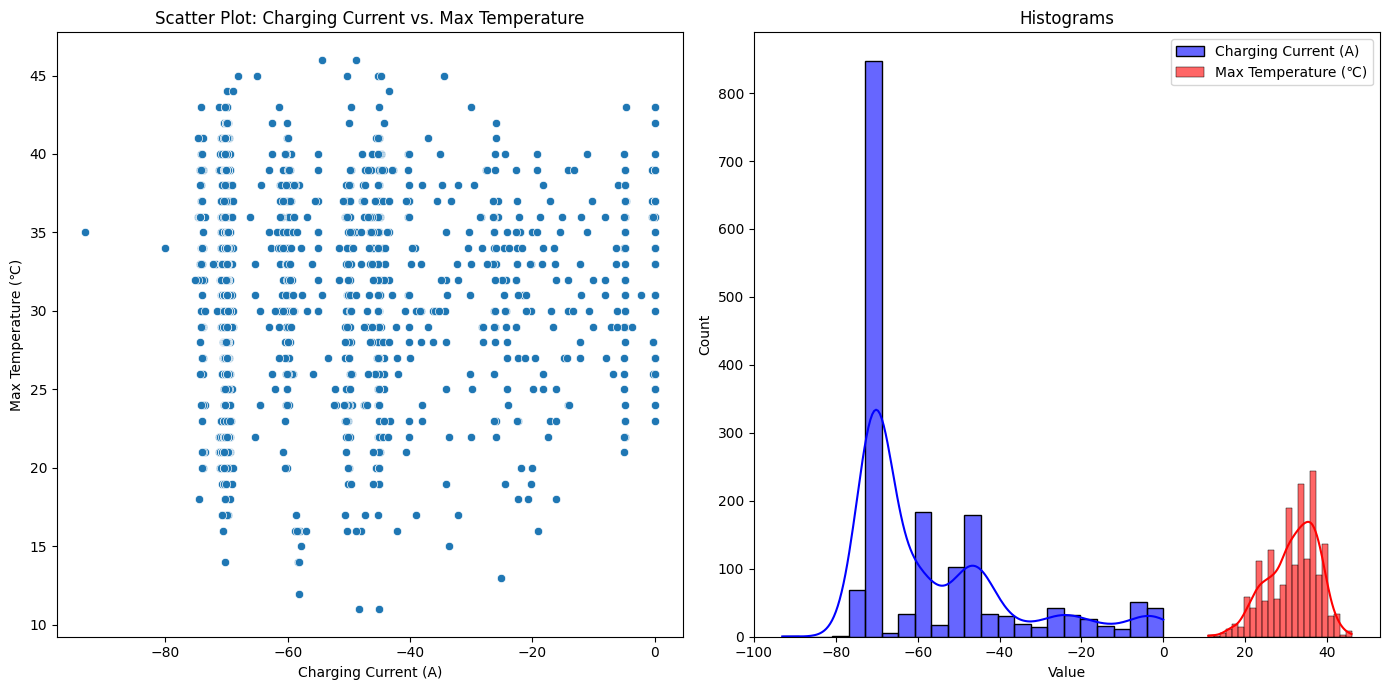

Correlation coefficient between Charging Current and Max Temperature: -0.02
P-value: 4.85e-01
The negative correlation indicates that higher charging currents are associated with lower temperatures.
The correlation is not statistically significant.

Higher charging currents can result in increased temperatures due to the higher energy input. 
This increased temperature can accelerate the aging process of the battery by promoting faster chemical reactions within the cells. 
Maintaining lower charging currents or implementing efficient cooling systems can help mitigate these effects and prolong battery life.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assuming df is your DataFrame already loaded with necessary columns
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Step 1: Ensure data types are correct and handle missing values if any
df['charge_current (A)'] = pd.to_numeric(df['charge_current (A)'], errors='coerce')
df['max_temperature (℃)'] = pd.to_numeric(df['max_temperature (℃)'], errors='coerce')

# Drop rows with missing values in the columns of interest
df = df.dropna(subset=['charge_current (A)', 'max_temperature (℃)'])

# Step 2: Descriptive Statistics
print("Descriptive Statistics for Charging Current (A):")
print(df['charge_current (A)'].describe())
print("\nDescriptive Statistics for Maximum Temperature (℃):")
print(df['max_temperature (℃)'].describe())

# Step 3: Visualization
plt.figure(figsize=(14, 7))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['charge_current (A)'], y=df['max_temperature (℃)'])
plt.title('Scatter Plot: Charging Current vs. Max Temperature')
plt.xlabel('Charging Current (A)')
plt.ylabel('Max Temperature (℃)')

# Histograms
plt.subplot(1, 2, 2)
sns.histplot(df['charge_current (A)'], kde=True, label='Charging Current (A)', color='blue', alpha=0.6)
sns.histplot(df['max_temperature (℃)'], kde=True, label='Max Temperature (℃)', color='red', alpha=0.6)
plt.title('Histograms')
plt.xlabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4: Correlation Analysis
correlation, p_value = pearsonr(df['charge_current (A)'], df['max_temperature (℃)'])
print(f'Correlation coefficient between Charging Current and Max Temperature: {correlation:.2f}')
print(f'P-value: {p_value:.2e}')

# Step 5: Interpretation
if correlation > 0:
    print("The positive correlation indicates that higher charging currents are associated with higher temperatures.")
else:
    print("The negative correlation indicates that higher charging currents are associated with lower temperatures.")

if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

print("""
Higher charging currents can result in increased temperatures due to the higher energy input. 
This increased temperature can accelerate the aging process of the battery by promoting faster chemical reactions within the cells. 
Maintaining lower charging currents or implementing efficient cooling systems can help mitigate these effects and prolong battery life.
""")


In the pursuit of understanding factors that may contribute to the decrease in battery capacity, a descriptive analysis was conducted focusing on the relationship between charging current (A) and maximum temperature (℃). The data comprises various parameters such as state of charge (SOC), pack voltage, charge current, cell voltages, temperatures, energy, capacity, and session details, providing a comprehensive view of battery performance.

Descriptive statistics for the charging current reveal an average value of -56.34 A, with a standard deviation of 19.66 A, indicating a significant portion of the data involves high discharge currents. The median charging current is -69.50 A, highlighting the prevalence of high discharge scenarios in the dataset. In contrast, the maximum temperature during these sessions ranges from 11℃ to 46℃, with a median of 33℃, indicating that battery operations frequently reach high temperatures.

The analysis aimed to uncover a potential correlation between charging current and maximum temperature, hypothesizing that higher charging currents would lead to increased temperatures, thus accelerating battery aging by promoting faster chemical reactions within the cells. However, the correlation coefficient calculated between charging current and maximum temperature was -0.02, indicating a very weak negative relationship. This weak correlation was not statistically significant, as evidenced by the high p-value (0.485), suggesting that the observed relationship could be due to random chance.

Despite theoretical expectations, the data does not show a significant relationship between charging current and maximum temperature. This discrepancy may be attributed to effective cooling systems managing the heat generated during high-current charging or other operational conditions not captured in the data. The findings suggest that further investigation is required, including additional data on cooling system performance and ambient conditions, to draw more definitive conclusions.

In summary, while the analysis did not confirm a significant correlation between charging current and maximum temperature, it underscores the importance of managing charging conditions and cooling systems to mitigate potential temperature-induced aging effects on batteries. Future research should focus on capturing more comprehensive data to better understand and address these critical factors.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=119995d2-42f9-4679-a55c-cd52fa6a2421' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>